# Import Statements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
from astropy.io import fits
from astropy.nddata import CCDData
from astropy.table import Table
from tqdm.notebook import tqdm
from astropy.stats import sigma_clipped_stats
from astropy.visualization import simple_norm
from scipy.ndimage import gaussian_filter
from copy import deepcopy
from photutils import make_source_mask
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
import sep

## Description of Task

On the night of Oct 22 2023, three targets were observed at AS Vidojevica from the 1.4m Milankovic telescope. They are: 

1. Mrk 335

2. Mrk 6

3. Mrk 817

The seeing that night was too poor to take further images. 

The calibration files are provided along with the science images. Every image has an underlying bias associated with it. Thus, a master bias must be created from 0s exposures with the cap closed. This bias is subtracted from every subsequent image.

The same procedure is done at different exposures to obtain dark current frames. These are subtracted from the science and flat images in order to remove the underlying dark current associated with each of them. The frames can be scaled with the exposure time as CCDs are conventionally assumed to scale linearly with exposure time. Dark frames are made into a master dark.(https://hamamatsu.magnet.fsu.edu/articles/ccdlinearity.html).

Finally, flat images are obtained from a short exposure of the sky (or in some other cases, a lamp on a wall). This is to correct for distortions in the image. The flats are combined into a master flat and the images are normalized by the flat.

With all of these steps, the image is calibrated and the photometry can be performed

The following image describes this process (but does not include the dark frames) (Courtesy of https://www.slideserve.com/gene/ccd-image-processing-issues-solutions):

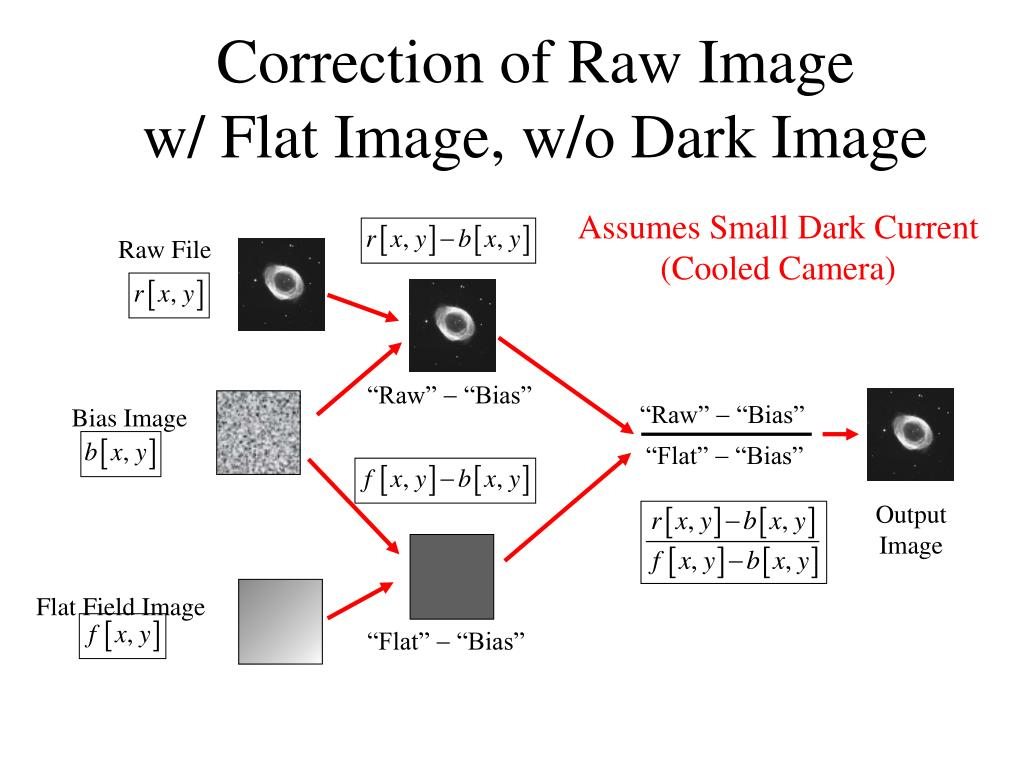

# Loading and Grouping Files

I saved the files in a folder called Vidojevica Spectra

In [2]:
#Getting list of filenames in the spectra file
file_names = os.listdir('./Vidojevica_Spectra/')

In [3]:
#Printing the list
file_names

['biasZalaz-1.fit',
 'biasZalaz-10.fit',
 'biasZalaz-2.fit',
 'biasZalaz-3.fit',
 'biasZalaz-4.fit',
 'biasZalaz-5.fit',
 'biasZalaz-6.fit',
 'biasZalaz-7.fit',
 'biasZalaz-8.fit',
 'biasZalaz-9.fit',
 'dark600s-0001_D.fit',
 'dark600s-0002_D.fit',
 'dark600s-0003_D.fit',
 'dark600s-0004_D.fit',
 'dark600s-0005_D.fit',
 'dark600s-0006_D.fit',
 'dark600s-0007_D.fit',
 'dark600s-0008_D.fit',
 'dark600s-0009_D.fit',
 'dark600s-0010_D.fit',
 'darkZalaz-5sec-1.fit',
 'darkZalaz-5sec-10.fit',
 'darkZalaz-5sec-2.fit',
 'darkZalaz-5sec-3.fit',
 'darkZalaz-5sec-4.fit',
 'darkZalaz-5sec-5.fit',
 'darkZalaz-5sec-6.fit',
 'darkZalaz-5sec-7.fit',
 'darkZalaz-5sec-8.fit',
 'darkZalaz-5sec-9.fit',
 'dnevnik_posmatranja.xlsx',
 'easySlew_ALTIlist.vbs',
 'flatZalaz-5sec-1_B.fit',
 'flatZalaz-5sec-1_Ha.fit',
 'flatZalaz-5sec-1_HaContinuum.fit',
 'flatZalaz-5sec-1_R.fit',
 'flatZalaz-5sec-1_SII.fit',
 'flatZalaz-5sec-1_V.fit',
 'flatZalaz-5sec-2_B.fit',
 'flatZalaz-5sec-2_Ha.fit',
 'flatZalaz-5sec-2_HaCo

In [4]:
#The filters that we took the observations in
#Note that HaContinuum and cnt are the same filter but file names are different
filter_names = ['B','Ha','cnt','R','SII','V']

In [5]:
def load_fits_files(Filenames = './Vidojevica_Spectra/*.fit'):
    #Loads fits files that are named in a certain way
    filenames = glob.glob(Filenames)
    files = []
    for i in filenames:
        files.append(fits.open(i))
    return files

In [6]:
def plot_fits_file(data,filename = None,norm_func = 'sqrt',inverse = False,percent = 100):
    #Plotting a fits file with imshow and a simple norm
    #We can also invert the colormap or cut off the pixels above a certain percentile
    #Note that all the counts are in ADU
    plt.figure()
    if filename != None:
        plt.title(filename)
    if inverse:
        cmap = 'Greys_r'
    else:
        cmap = 'Greys'
    plt.imshow(data,cmap = cmap,norm = simple_norm(data,norm_func,percent = percent),origin = 'lower')
    plt.xlabel('X')
    plt.ylabel('Y')
    cbar = plt.colorbar()
    cbar.set_label('ADU')

In [7]:
def average_files(files,flat_norm = False,subtract = False,subtract_files = None):
    #Create a master median file, can also normalize against itself or subtract biases
    data = []
    for i in files:
        some_data = i[0].data
        if subtract:
            some_data = some_data-subtract_files
        if flat_norm:
            some_data = some_data/np.median(some_data)
        data.append(some_data)
    master_file = np.median(data,axis = 0)
    return master_file

#### Bias

The first task is to create a master bias file that will be subtracted from all subsequent images

In [8]:
#The bias files all have bias in the heading
bias = load_fits_files('./Vidojevica_Spectra/bias*.fit')

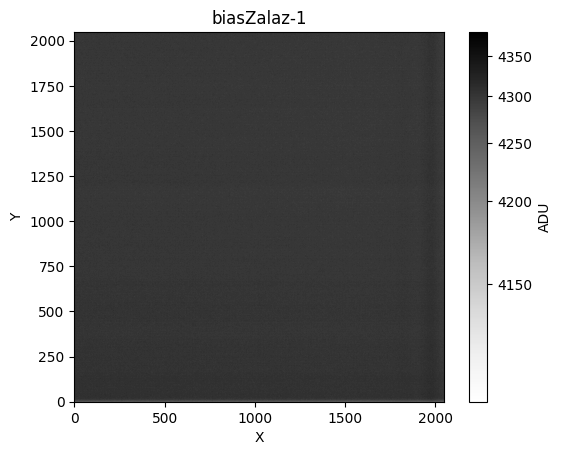

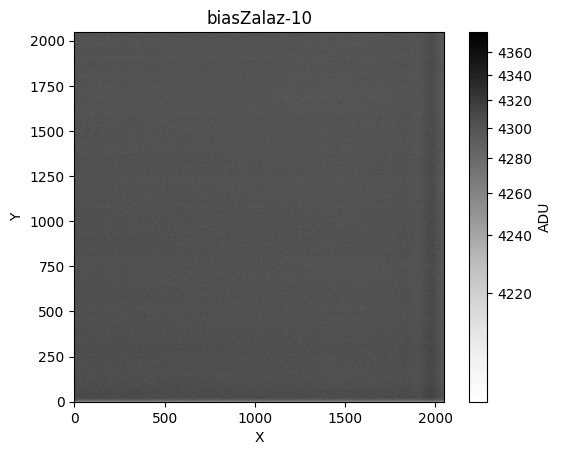

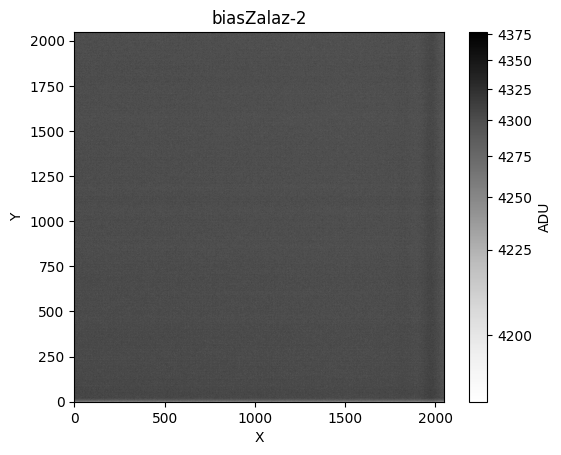

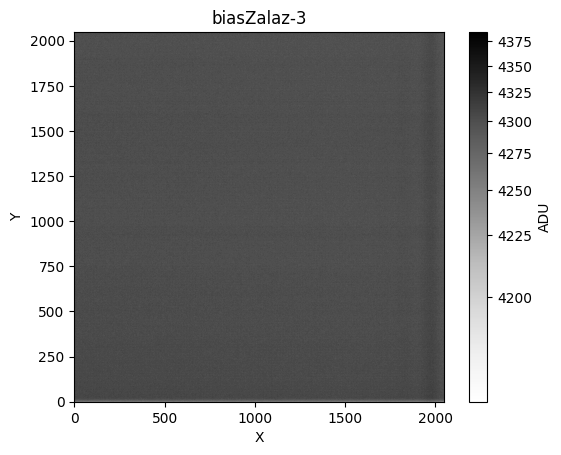

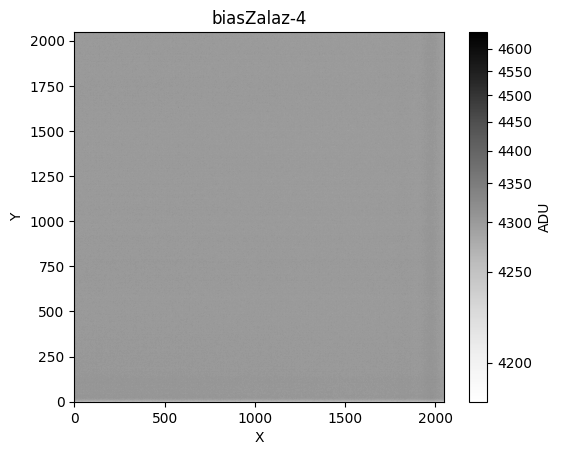

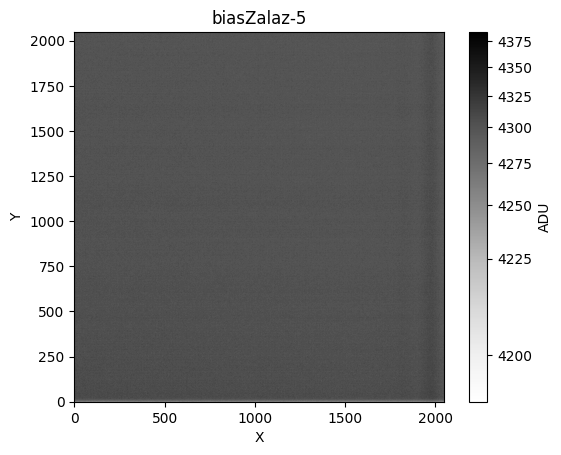

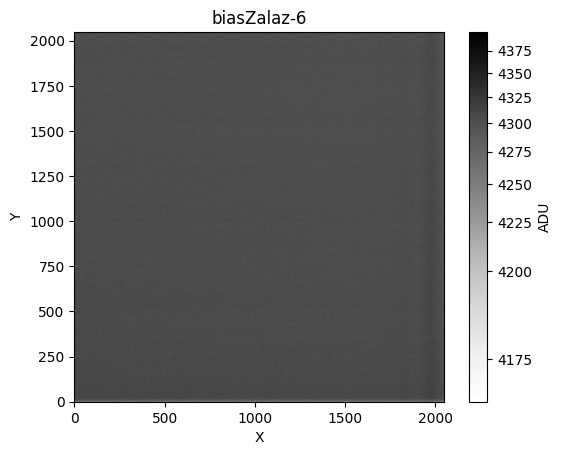

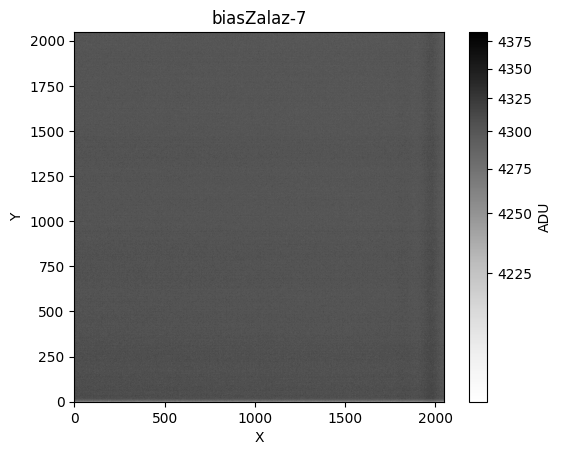

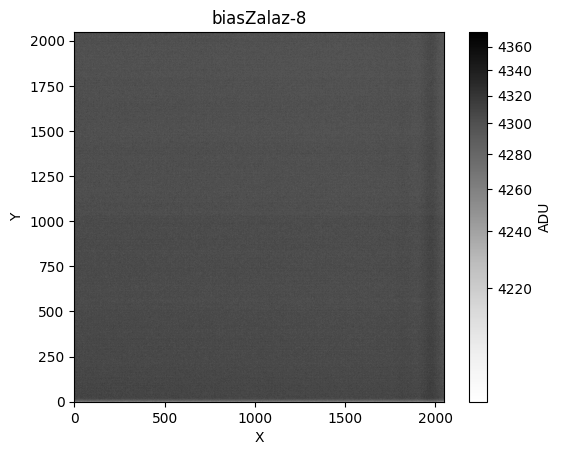

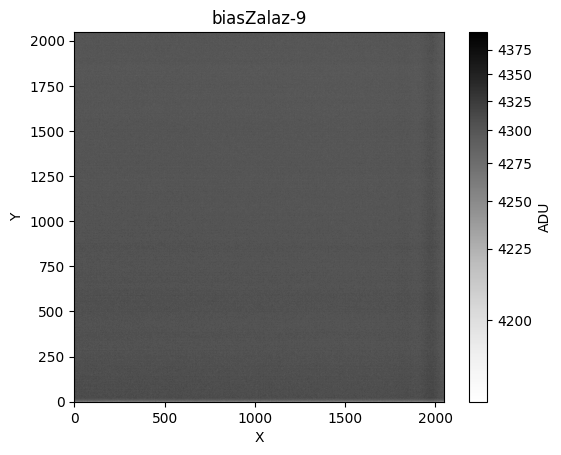

In [9]:
#Plotting the bias files
for bias_one in bias:
    plot_fits_file(bias_one[0].data,bias_one.filename()[21:-4],'sqrt')

In [10]:
#Creating the master file from the biases
master_bias = average_files(bias)

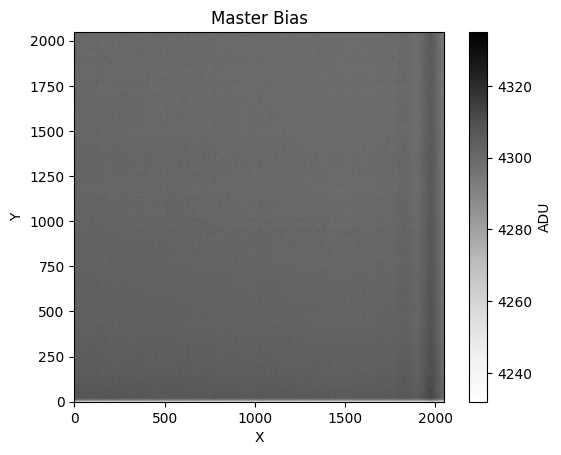

In [11]:
#Plotting the master bias
plot_fits_file(master_bias,'Master Bias','linear')

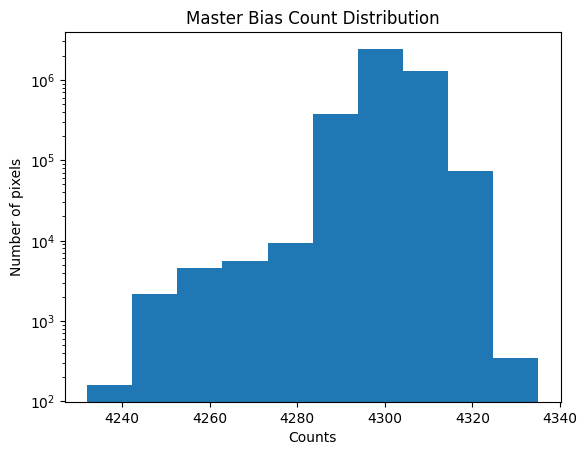

In [12]:
plt.hist(np.reshape(master_bias,-1))
plt.title('Master Bias Count Distribution')
plt.xlabel('Counts')
plt.ylabel('Number of pixels')
plt.yscale('log')
plt.show()

Note that the pixels have high count values, but it remains to be seen if this is fine compared to the other exposures

#### Dark 600s

In [13]:
#Getting the 600s exposure darks (all labeleed as dark600s)
dark600s = load_fits_files('./Vidojevica_Spectra/dark600s*.fit')

In [14]:
#Creating the master 600s dark
master_dark600s = average_files(dark600s,subtract=True,subtract_files=master_bias)

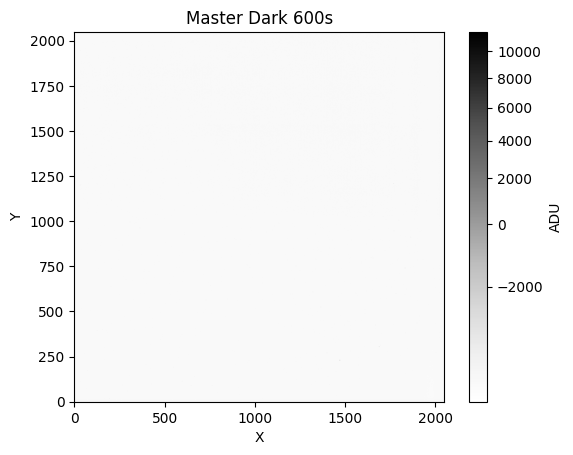

In [15]:
#Plotting the files
plot_fits_file(master_dark600s,'Master Dark 600s','sqrt')

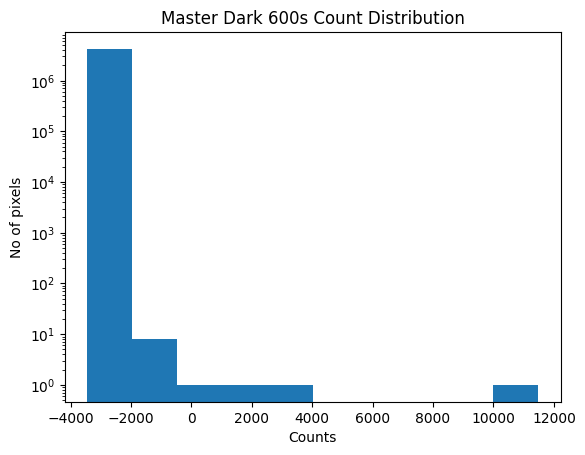

In [16]:
plt.hist(np.reshape(master_dark600s,-1))
plt.title('Master Dark 600s Count Distribution')
plt.xlabel('Counts')
plt.ylabel('No of pixels')
plt.yscale('log')

Note that the most of the pixels are negative indicating that the dark 600s is more than the bias. This is a strange result, possibly indicating some mistake with the CCD

#### darkZalaz5s

In [17]:
darkzalaz5s = load_fits_files('./Vidojevica_Spectra/darkZalaz*.fit')

In [18]:
master_dark5s = average_files(darkzalaz5s,subtract=True,subtract_files=master_bias)

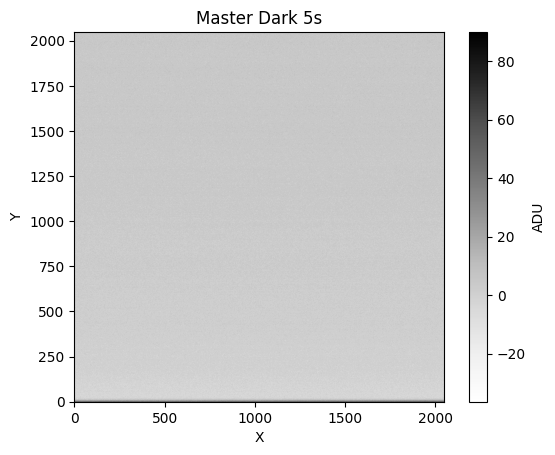

In [19]:
plot_fits_file(master_dark5s,'Master Dark 5s','linear')

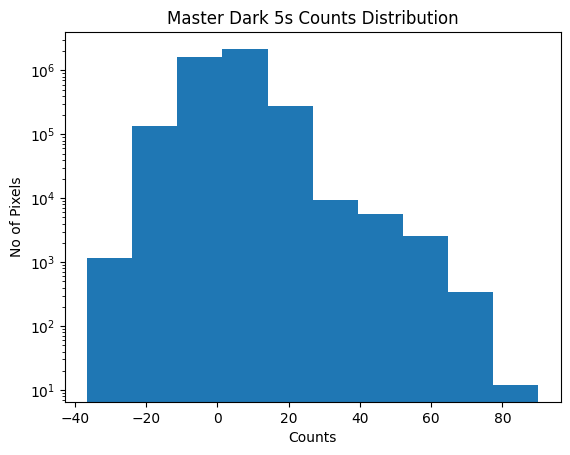

In [20]:
plt.hist(np.reshape(master_dark5s,-1))
plt.title('Master Dark 5s Counts Distribution')
plt.xlabel('Counts')
plt.ylabel('No of Pixels')
plt.yscale('log')

Weirdly, the 5s frames have higher counts than the 600s exposures. There are still very many negative values further indicating the CCD problem

#### scDarkZalaz200s

In [21]:
#The final dark frames have a 200s exposure and are indicated with scDark (Assumed to be science dark)
scdarkzalaz200s = load_fits_files('./Vidojevica_Spectra/scDark*.fit')

In [22]:
master_dark200s = average_files(scdarkzalaz200s,subtract=True,subtract_files=master_bias)

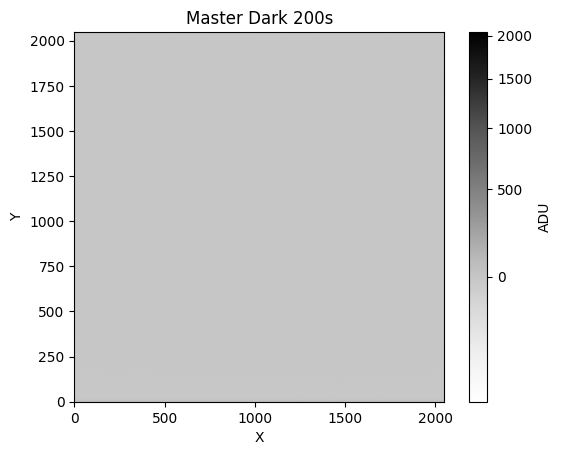

In [23]:
plot_fits_file(master_dark200s,'Master Dark 200s','sqrt')

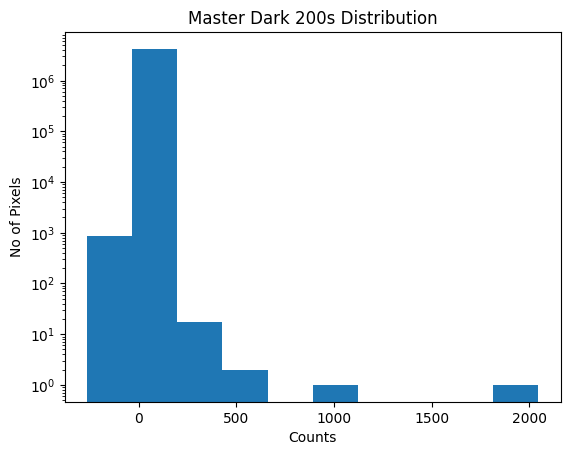

In [24]:
#Better than 600s but still slightly negative
plt.title('Master Dark 200s Distribution')
plt.hist(np.reshape(master_dark200s,-1))
plt.xlabel('Counts')
plt.ylabel('No of Pixels')
plt.yscale('log')

Again, 200s is better than 600s. There are still many negative values and a weird distribution indicating a problem with the CCD

#### flatZalaz

In [25]:
#Getting the flat files into a list
flatzalaz_list = []
for i in filter_names:
    if i == 'cnt':
        i = 'HaContinuum'
    flatzalazonefilt = []
    flatzalazonefilt = load_fits_files(f'./Vidojevica_Spectra/flat*{i}.fit')
    flatzalaz_list.append(flatzalazonefilt)

In [26]:
#Making the flat list into a dictionary
flatzalaz = {filter_names[i]:flatzalaz_list[i] for i in range(len(filter_names))}

In [27]:
#Creating the master flats from bias and dark corrected files
master_flat_list = []
for i in flatzalaz:
    master_flat_onefilter = average_files(flatzalaz[i],flat_norm=True,subtract=True,subtract_files=master_bias+master_dark5s)
    master_flat_list.append(master_flat_onefilter)

In [28]:
master_flat = {filter_names[i]:master_flat_list[i] for i in range(len(filter_names))}

The following flat frames can be changed with the plotting_filter_flat keyword

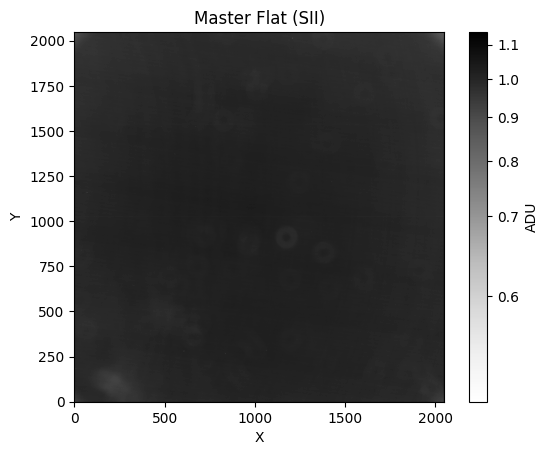

In [29]:
plotting_filter_flat = 'SII'
plot_fits_file(master_flat[plotting_filter_flat],'Master Flat ({})'.format(plotting_filter_flat),'sqrt')

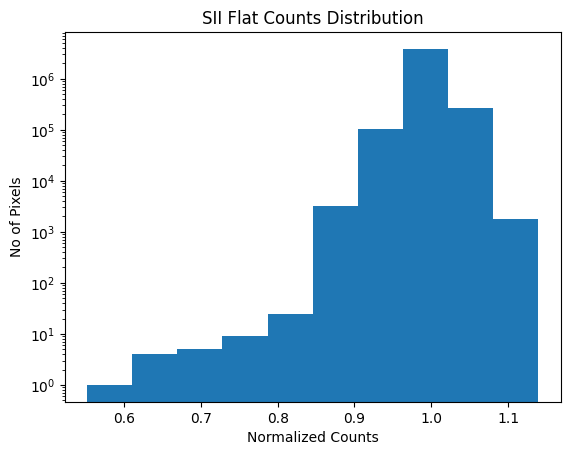

In [30]:
plt.hist(np.reshape(master_flat[plotting_filter_flat],-1))
plt.title('{} Flat Counts Distribution'.format(plotting_filter_flat))
plt.xlabel('Normalized Counts')
plt.ylabel('No of Pixels')
plt.yscale('log')

There seems to be no big issues with the flat frames, though some dust grains and deformations are observed 

#### Mrk335

##### Astrometry Description

The files can be automatically loaded from the same directory as the other files that we were doing. However, we want to know the astrometry for the science images so that we can efficiently capture the location of the target star and the calibration stars from knowing their ra and dec. So, we use a software to add astrometry coordinates to our images

In this case, we use https://nova.astrometry.net/. This website is able to assign coordinates to an image by matching it to known images from the database. It is possible to acces through an API, but in this case, the images were uploaded and downloaded manually and saved in a file on the computer. Finally these files were reduced as shown below

In [41]:
#Loading the Mrk355 fits files
Mrk335_list = []
for i in filter_names:
    Mrk335onefilt = []
    Mrk335onefilt = load_fits_files(f'Mrk335_Astrometry/Mrk335*{i}.fits')
    Mrk335_list.append(Mrk335onefilt)

In [42]:
#Converting the list into a dictionary
Mrk335 = {filter_names[i]:Mrk335_list[i] for i in range(len(filter_names))}

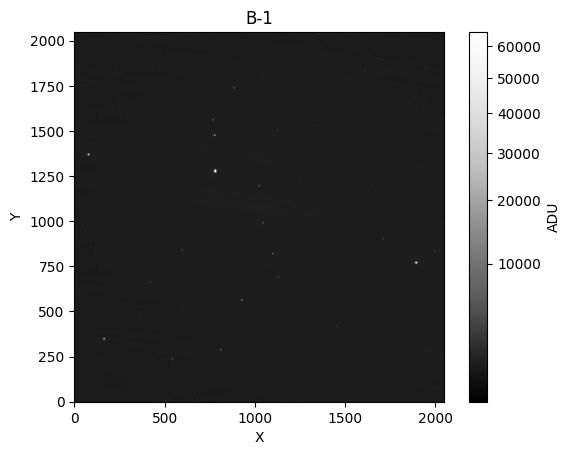

In [43]:
#Plotting the image (Can be changed with the keywords plot_filter and plot_frame)
plot_filter = 'B'
plot_frame = 1
plot_fits_file(Mrk335[plot_filter][plot_frame][0].data,str(plot_filter)+'-'+str(plot_frame),'sqrt',True)

In [44]:
#Calibrating the files
#First, the bias and dark are removed from image
#Then, it is normalized by the flat
#Finally, it is written to a new fits file
calibrated_images = {'B':[],'Ha':[],'cnt':[],'R':[],'SII':[],'V':[]}
for filter_name in tqdm(filter_names):
    calibrated_images_filt = []
    for j,image in enumerate(Mrk335[filter_name]):
        exptime = Mrk335[filter_name][j][0].header['EXPTIME']
        #Subtracting the bias and darks
        calibrated_file = CCDData(Mrk335[filter_name][j][0].data,unit = 'adu')-master_bias-(master_dark200s/exptime*200)
        #Normalizing by the flats
        calibrated_file = calibrated_file/master_flat[filter_name]
        calibrated_images_filt.append(calibrated_file)
        #Add SIP to the CTYPE in the headers if not present (This is so that it doesn't raise the warning)
        if 'SIP' not in Mrk335[filter_name][j][0].header['CTYPE1'] and 'SIP' not in Mrk335[filter_name][j][0].header['CTYPE2']:
            Mrk335[filter_name][j][0].header['CTYPE1'] += '-SIP'
            Mrk335[filter_name][j][0].header['CTYPE2'] += '-SIP'
        wcs = WCS(Mrk335[filter_name][j][0].header,relax = True)
        Mrk335[filter_name][j][0].data = calibrated_file
        Mrk335[filter_name][j][0].header.update(wcs.to_header())
        Mrk335[filter_name][j][0].writeto("Mrk335_Calibrated/cal" + Mrk335[filter_name][j].filename()[18:], overwrite=True)
    calibrated_images[filter_name] = calibrated_images_filt

  0%|          | 0/6 [00:00<?, ?it/s]

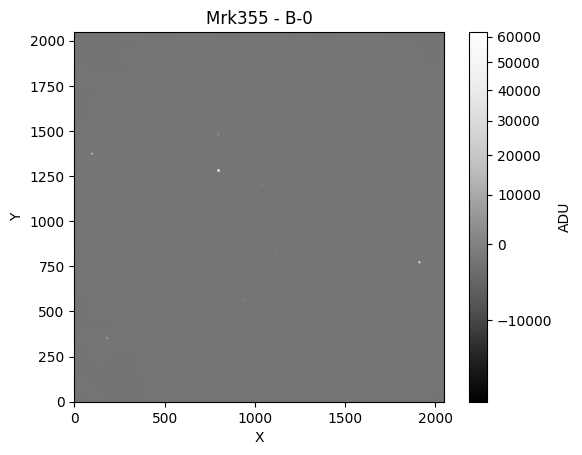

In [450]:
filt = 'B'
image = 0
plot_fits_file(calibrated_images[filt][image],f'Mrk355 - {filt}-{image}','sqrt',True)

It can be seen that the image reduction is done very poorly. Many sources become very faint and there are many background counts as well with many negative counts. Thus, the obtained fluxes will be poor due to bad calibration images

#### Mrk 335 Photometry

Now that the stars are reduced and have the astrometry associated, we can identify the sources and select the ones that match with the target and calibration stars

Our science target will be Mrk335 as it had the best seeing and has ample literary sources. Mrk335 is a narrow line Seyfert 1 Galaxy. Mrk335 shows a high degree of variability in the X-Ray with a mild degree of variability in the Optical and UV (https://iopscience.iop.org/article/10.3847/1538-4357/acbcd3). It has the coordinates of:

RA: 00 06 19.5372339024 
Dec: +20 12 10.617404076  (https://simbad.cds.unistra.fr/simbad/sim-ref?bibcode=2020yCat.1350....0G)

In this exercise, we will determain the photometry of Mrk335 in two different methods. The first will be through Gaussian fitting to the PSF and the second will be through aperture photometry.

In [45]:
#Necessary Imports
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from astropy.coordinates import SkyCoord
import astropy.units as u
from photutils.aperture import CircularAperture,CircularAnnulus

In [160]:
#This is the coordinates of the Target Object Mrk335
Mrk335_coord = SkyCoord('00 06 19.7 +20 12 12.1', unit=(u.hourangle, u.deg))

In [161]:
#They are converted to degrees which can be later converted to the pixels
Mrk335_coord_list = [Mrk335_coord.ra.deg,Mrk335_coord.dec.deg]

In [163]:
#Loading Mrk335 from the corrected files
Mrk335_list = []
filter_names = ['B','Ha','cnt','R','SII','V']
for i in filter_names:
    Mrk335onefilt = []
    Mrk335onefilt = load_fits_files(f'Mrk335_Calibrated/calMrk335*{i}.fits')
    Mrk335_list.append(Mrk335onefilt)
    
Mrk335= {filter_names[i]:Mrk335_list[i] for i in range(len(filter_names))}

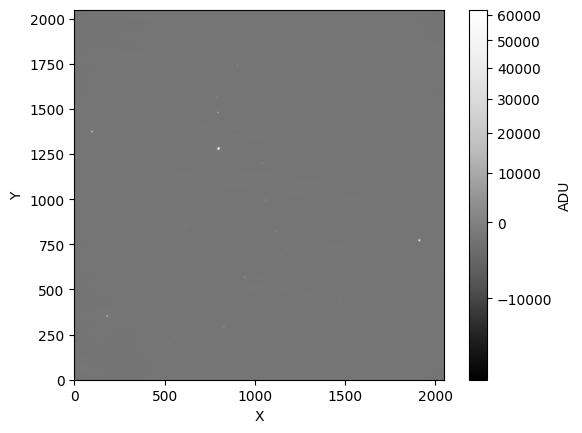

In [164]:
#Looking at one of them to see if they match the calibration
plot_fits_file(Mrk335['B'][0][0].data,inverse = True)

###### Source identification

The source identification is done using a nice algorithm that is implemented in the photfilters based on DAOFIND. (https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html) (https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract)

Then the list of sources is compared with the target position to find the one closest to the target. Then, the flux is automatically calcualted by the algorithm by fitting to the PSF.

In [167]:
def source_pos_and_flux(input_files,target_pos,\
                        filter_names = ['B','Ha','cnt','R','SII','V'],fwhm = 3.0,sigma_lower = 3.0, treshold_factor = 5.):
    #Identifying sources using a DAO Starfinder method
    sources = {'B':[],'Ha':[],'cnt':[],'R':[],'SII':[],'V':[]}
    fluxes = {'B':[],'Ha':[],'cnt':[],'R':[],'SII':[],'V':[]}
    distances = {'B':[],'Ha':[],'cnt':[],'R':[],'SII':[],'V':[]}
    for Filter in tqdm(filter_names,desc = 'Looping through Filters'):
        sources_one_filt = []
        fluxes_one_filt = []
        distances_one_filt = []
        for i in range(len(input_files[Filter])):
            if 'SIP' not in input_files[Filter][i][0].header['CTYPE1'] and 'SIP' not in input_files[Filter][i][0].header['CTYPE2']:
                input_files[Filter][i][0].header['CTYPE1'] += '-SIP'
                input_files[Filter][i][0].header['CTYPE2'] += '-SIP'
            #Get the wcs convertion of that frame
            wcs = WCS(input_files[Filter][i][0].header)
            #Find the sources
            mean, median, std = sigma_clipped_stats(input_files[Filter][i][0].data, sigma_lower=sigma_lower)  
            daofind = DAOStarFinder(fwhm=fwhm, threshold = treshold_factor*std)  
            sources_one_img = daofind(input_files[Filter][i][0].data-median)
            #Convert the Source to pixels
            pixx,pixy = wcs.all_world2pix(target_pos[0],target_pos[1],0)
            #Now find the one closest to source and to a reference star
            closest_distance = 1000000
            for pos in range(len(sources_one_img)):
                x_coord = sources_one_img[pos]['xcentroid']
                y_coord = sources_one_img[pos]['ycentroid']
                distance = np.sqrt((pixx-x_coord)**2+(pixy-y_coord)**2)
                if distance < closest_distance:
                    closest_pos = pos
                    closest_distance = distance
                    source_cent = [x_coord,y_coord]
            #Put them all into different lists
            sources_one_filt.append(source_cent)
            fluxes_one_filt.append(sources_one_img[closest_pos]['flux'])
            distances_one_filt.append(closest_distance)
        #Put each list into a different filter
        sources[Filter] = sources_one_filt
        fluxes[Filter] = fluxes_one_filt
        distances[Filter] = distances_one_filt
    return sources,fluxes,distances

## Photometry Method 1

Since we used the DAOStarFinder, we can take the flux straight from the measurement. The flux calculated here (See https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html for more details) already subtracts the sky background from subtracting the treshold that was defined earlier (5 standard deviations). Finally, we will compare this flux with the reference star fluxes obtained by the same method. The division of these fluxes will cancel out and then the apparent magnitude of the star can be captured. This can then be converted to absolute magnitude through the distance measurement

Part of the task was to experiment with the aperture radius. However, in this process, we are fitting to a Gaussian instead of making an aperture radius. Thus, the experiment will be with the FWHM of the Gaussian and the treshold for detection. We will experiment with a grid of 3x3 measurements. The threshold will be 3std, 5std and 10std, while the FWHM will be 1,3 and 5

Note that the quantity will be called flux to keep with the convention adopted in Photutils. However, this is not the physical flux that the CCD recieves. For that, the gain and exposure time have to be factored into these counts as well. When the flux is compared with standard stars, these factors would be the same and thus, they would disappear when divided, giving us the true magnitude

In [169]:
fluxes_all = []
distances_all = []
for fwhm in [1.0,3.0,5.0]:
    fluxes_fwhm = []
    distances_fwhm = []
    for treshold_fact in [3.0,5.0,10.0]:
        centers,fluxes,distances = source_pos_and_flux(Mrk335,Mrk335_coord_list,fwhm = fwhm,sigma_lower=fwhm,treshold_factor=treshold_fact)
        fluxes_fwhm.append(fluxes)
        distances_fwhm.append(distances)
    fluxes_all.append(fluxes_fwhm)
    distances_all.append(distances_fwhm)

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

In [170]:
fluxes_all[0][0]

{'B': [10.41786867286464, 18.544428565702756, 14.657511470651892],
 'Ha': [5.75392779778338, 3.94367818151627, 4.039390479812009],
 'cnt': [4.293459710930523, 4.137227812671531, 3.740911477072554],
 'R': [1.2686291428369267, 58.15202698102353, 72.86128884486908],
 'SII': [68.0788267747372, 55.816416167462464, 31.71349779640751],
 'V': [1.0148388516146407, 1.0013757007818915, 33.47711823393217]}

In [171]:
#The distance from the detected source to the object doesn't change much based on the function
distances_all

[[{'B': [6.756846430087807, 6.029780730921729, 7.333870956574666],
   'Ha': [6.21140214454561, 8.054725035827097, 6.017085137188868],
   'cnt': [6.143372236105321, 6.780386017697069, 7.4744167738746325],
   'R': [3.475721815958076, 6.329559949585473, 6.246649026219683],
   'SII': [6.344837301755019, 7.20560505367705, 7.331684020082212],
   'V': [4.272817394258864, 4.18264347027787, 5.867294581053142]},
  {'B': [6.756846430087807, 6.029780730921729, 7.333870956574666],
   'Ha': [6.21140214454561, 8.054725035827097, 6.017085137188868],
   'cnt': [6.143372236105321, 6.780386017697069, 7.4744167738746325],
   'R': [6.47455010909285, 6.329559949585473, 6.246649026219683],
   'SII': [6.344837301755019, 7.20560505367705, 7.331684020082212],
   'V': [6.628254571887274, 7.022657913030753, 5.867294581053142]},
  {'B': [6.756846430087807, 6.029780730921729, 7.333870956574666],
   'Ha': [6.21140214454561, 8.054725035827097, 6.017085137188868],
   'cnt': [6.143372236105321, 6.780386017697069, 7.474

In [172]:
fluxes_all

[[{'B': [10.41786867286464, 18.544428565702756, 14.657511470651892],
   'Ha': [5.75392779778338, 3.94367818151627, 4.039390479812009],
   'cnt': [4.293459710930523, 4.137227812671531, 3.740911477072554],
   'R': [1.2686291428369267, 58.15202698102353, 72.86128884486908],
   'SII': [68.0788267747372, 55.816416167462464, 31.71349779640751],
   'V': [1.0148388516146407, 1.0013757007818915, 33.47711823393217]},
  {'B': [6.250721203718785, 11.126657139421654, 8.794506882391136],
   'Ha': [3.4523566786700273, 2.3662069089097617, 2.423634287887206],
   'cnt': [2.5760758265583137, 2.4823366876029183, 2.2445468862435325],
   'R': [25.829994054191154, 34.89121618861412, 43.716773306921446],
   'SII': [40.84729606484232, 33.489849700477485, 19.028098677844504],
   'V': [10.756881882698146, 24.564555191275495, 20.0862709403593]},
  {'B': [3.1253606018593927, 5.563328569710827, 4.397253441195568],
   'Ha': [1.7261783393350136, 1.1831034544548809, 1.211817143943603],
   'cnt': [1.2880379132791568, 1

While the counts are not exactly consistent, they give a similar magnitude of values at least. Then, they can be converted into fluxes. We will also take the median since there are some extreme jumps at a few points

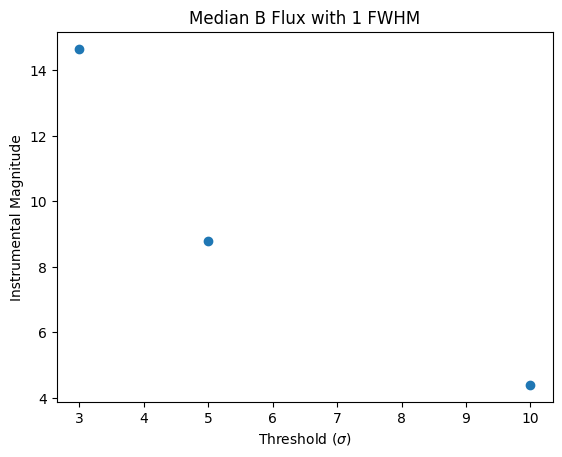

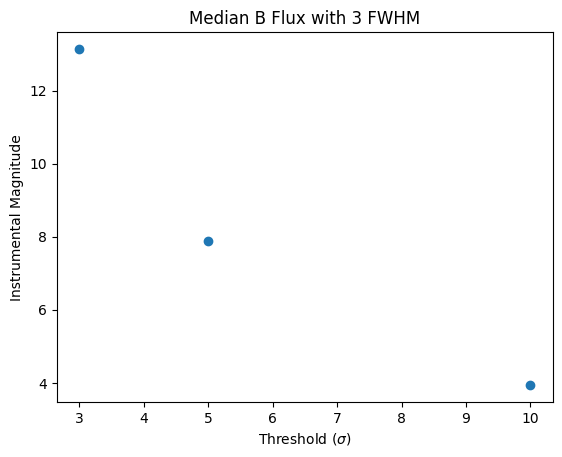

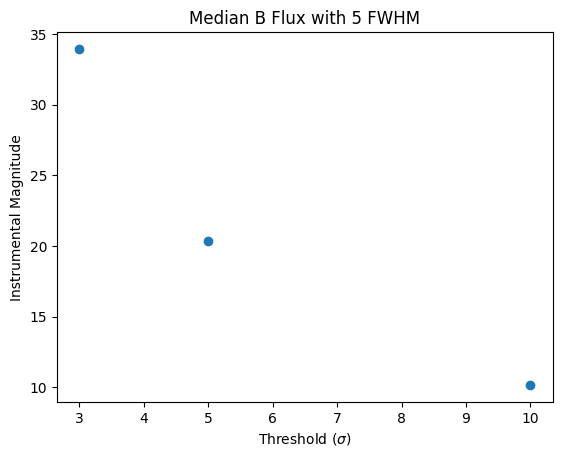

In [177]:
Filter = 'B'
for i in range(3):
    mean_flux = []
    for j in range(3):
        mean_flux.append(np.median(fluxes_all[i][j][Filter]))
    plt.figure()
    plt.scatter([3,5,10],mean_flux)
    plt.xlabel(r'Threshold ($\sigma$)')
    plt.ylabel('Instrumental Magnitude')
    plt.title(r'Median {} Flux with {} FWHM'.format(Filter,[1,3,5][i]))

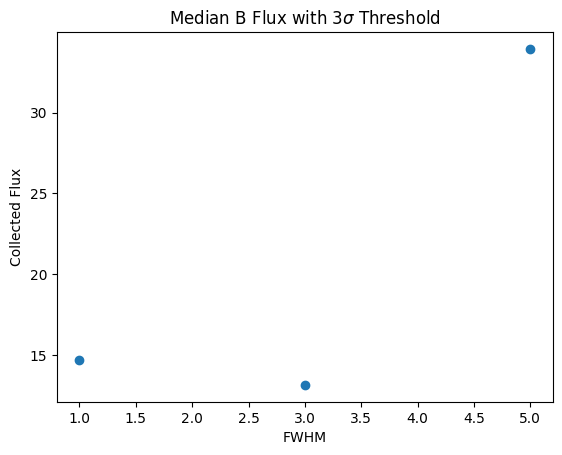

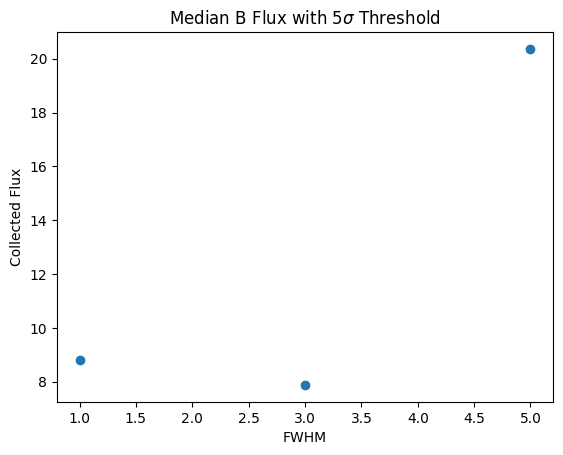

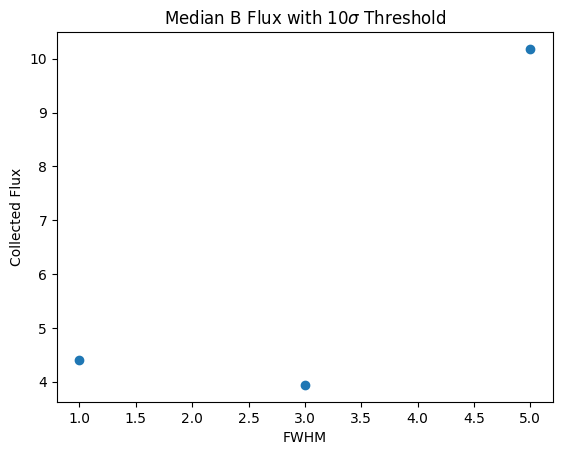

In [178]:
Filter = 'B'
for i in range(3):
    mean_flux = []
    for j in range(3):
        mean_flux.append(np.median(fluxes_all[j][i][Filter]))
    plt.figure()
    plt.scatter([1,3,5],mean_flux)
    plt.xlabel(r'FWHM')
    plt.ylabel('Collected Flux')
    plt.title(r'Median {} Flux with ${}\sigma$ Threshold'.format(Filter,[3,5,10][i]))

It can be seem that the counts decrease as the threshold increases. This makes sense as that means that more of the background is subtracted.

It is also seen that increasing the FWHM increases the number of counts. The FWHM doesn't seem to matter too much between 1 and 3, but siginificantly increases the number of counts at 5. Thus, we will stick with 2 for the final value. We will also choose a 3 sigma threshold to yield slightly higher counts and because the seeing was very bad for the night (Thus the image might have a lower sigma)

In [179]:
centers,fluxes,distances = source_pos_and_flux(Mrk335,Mrk335_coord_list,fwhm = 2,sigma_lower=3,treshold_factor=3)

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

In [184]:
def averaging_all_filters_fluxes(fluxes):
    #Averaging the fluxes by taking the mean in each filter. 
    averaged_fluxes = {'B':[],'Ha':[],'cnt':[],'R':[],'SII':[],'V':[]}
    for Filter in filter_names:
        averaged_fluxes[Filter] = np.mean(fluxes[Filter])
    return averaged_fluxes

In [185]:
#The average flux in each filter is as follows
Mrk355_instrumental_fluxes = averaging_all_filters_fluxes(fluxes)

In [186]:
Mrk355_instrumental_fluxes

{'B': 12.28588416783907,
 'Ha': 3.741430550517082,
 'cnt': 3.2267623563106738,
 'R': 43.03103455198788,
 'SII': 38.52912978257623,
 'V': 26.092632200622674}

While most of the values make sense, the SII band has very flux values despite being a narrow band filter. This indicates that there is some mistake in the calibration of the SII filter. This is something to note to be checked in the aperture photometry also. 

Now that the magnitudes are obtained, they need to be checked with the standard stars. This is only done in the B,V and R filters as the other filters need additional steps. We will check with 3 different stars as calibrations from literature (https://ui.adsabs.harvard.edu/abs/2005Ap.....48..304D/abstract).

In Doroshenko et al., they are listed as objects 4, 1, and 2 as standard stars for Mrk 335. Their coordinates and magnitudes are listed below (Note that they do not have SII, Ha or Ha cont magnitudes, so a placeholder value of 1 for the magnitudes is provided). Below is a finding chart on a V band image with the standard stars marked with the numbering in Doroshenko et al. 
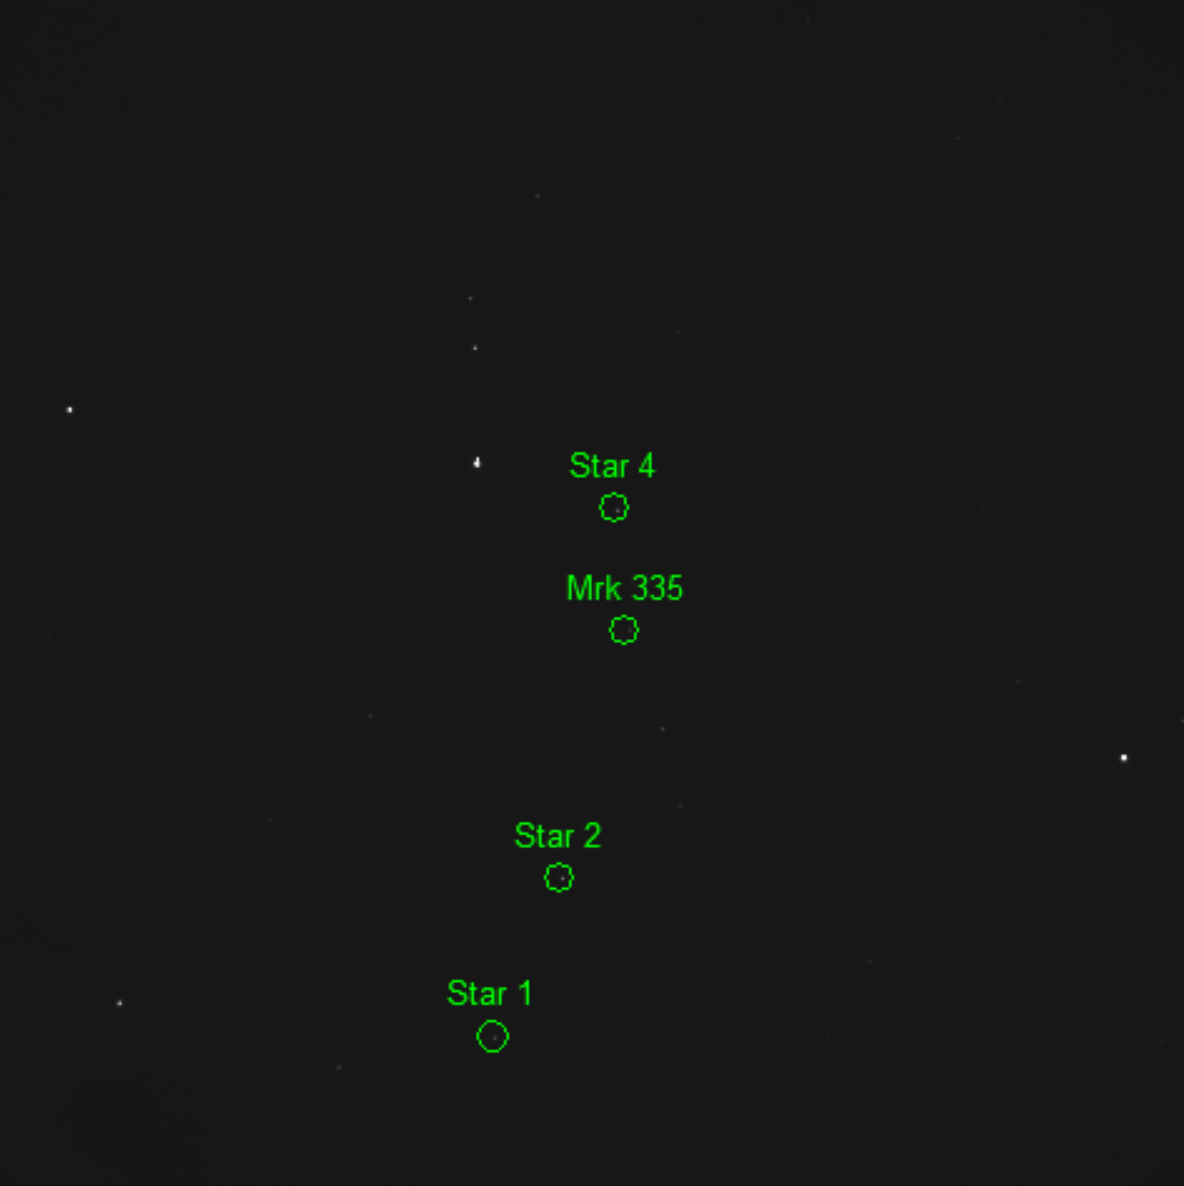

It should be noted that the stars will hereby be refered to as star 1 (originally 4), star 2(originally 1) and star 3 (Originally 2)

In [187]:
calibration_star_target_1 = [SkyCoord('00 06 20.2 +20 10 50.5', unit=(u.hourangle, u.deg)).ra.deg,SkyCoord('00 06 20.2 +20 10 50.5', unit=(u.hourangle, u.deg)).dec.deg]
calibration_star_target_2 = [SkyCoord('00 06 26.1 +20 16 44.2', unit=(u.hourangle, u.deg)).ra.deg,SkyCoord('00 06 26.1 +20 16 44.2', unit=(u.hourangle, u.deg)).dec.deg]
calibration_star_target_3 = [SkyCoord('00 06 22.9 +20 14 58.8', unit=(u.hourangle, u.deg)).ra.deg,SkyCoord('00 06 22.9 +20 14 58.8', unit=(u.hourangle, u.deg)).dec.deg]

In [188]:
calibration_star_1_fluxes = source_pos_and_flux(Mrk335,calibration_star_target_1,fwhm = 2,sigma_lower=3,treshold_factor=3)[1]
calibration_star_2_fluxes = source_pos_and_flux(Mrk335,calibration_star_target_2,fwhm = 2,sigma_lower=3,treshold_factor=3)[1]
calibration_star_3_fluxes = source_pos_and_flux(Mrk335,calibration_star_target_3,fwhm = 2,sigma_lower=3,treshold_factor=3)[1]

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

In [189]:
#Averaging the fluxes by taking the mean in each filter. Then, the 
cal_star_1_averaged_fluxes = averaging_all_filters_fluxes(calibration_star_1_fluxes)
cal_star_2_averaged_fluxes = averaging_all_filters_fluxes(calibration_star_2_fluxes)
cal_star_3_averaged_fluxes = averaging_all_filters_fluxes(calibration_star_3_fluxes)

In [190]:
def magnitude_calculation(fluxes_1,fluxes_2,apparent_mag_ref):
    #Averaging the fluxes by taking the mean in each filter. Then, the 
    magnitude = {'B':[],'Ha':[],'cnt':[],'R':[],'SII':[],'V':[]}
    for Filter in filter_names:
        magnitude[Filter] = -2.5*np.log10(fluxes_1[Filter]/fluxes_2[Filter])+apparent_mag_ref[Filter]
    return magnitude

In [281]:
Standard_Star_1_mags = {'B':15.406,'Ha':1,'cnt':1,'R':13.618,'SII':1,'V':14.251}
Standard_Star_2_mags = {'B':15.293,'Ha':1,'cnt':1,'R':14.124,'SII':1,'V':14.556}
Standard_Star_3_mags = {'B':14.883,'Ha':1,'cnt':1,'R':13.839,'SII':1,'V':14.229}

In [282]:
magnitude_1 = magnitude_calculation(Mrk355_instrumental_fluxes,cal_star_1_averaged_fluxes,Standard_Star_1_mags)
magnitude_2 = magnitude_calculation(Mrk355_instrumental_fluxes,cal_star_2_averaged_fluxes,Standard_Star_2_mags)
magnitude_3 = magnitude_calculation(Mrk355_instrumental_fluxes,cal_star_3_averaged_fluxes,Standard_Star_3_mags)

In [283]:
magnitude_1

{'B': 15.640314745654466,
 'Ha': 2.262296100329112,
 'cnt': 2.4658522720441542,
 'R': 14.67575080700761,
 'SII': -0.1796239129120747,
 'V': 15.326624065619201}

In [284]:
magnitude_dataframe = pd.concat((pd.DataFrame(magnitude_1,index = ['Standard Star 1']),pd.DataFrame(magnitude_2,index = ['Standard Star 2']),pd.DataFrame(magnitude_3,index = ['Standard Star 3'])))

In [285]:
magnitude_dataframe[['B','R','V']]

B          R          V
Standard Star 1  15.640315  14.675751  15.326624
Standard Star 2  15.431788  14.555891  15.134803
Standard Star 3  15.471798  14.684704  15.223406

It can be seen that the different standard stars don't defer by too much. However, when SIMBAD is checked, the apparent magnitude is :

B 14.19 

V 13.85 

(They are taken from:https://www.aanda.org/articles/aa/full_html/2010/10/aa14188-10/aa14188-10.html
)

Thus, the magnitudes calculated through this method are off. However, it can be seen that the nearly 0.3 difference between the B and V magnitudes are reproduced. 

As a final calculation, we will check the absolute magnitude using the NED Database (https://ned.ipac.caltech.edu/cgi-bin/nph-objsearch?objname=Markarian+335&extend=no&out_csys=Equatorial&out_equinox=J2000.0&obj_sort=RA+or+Longitude&of=pre_text&zv_breaker=30000.0&list_limit=5&img_stamp=YES)

$\mu = m - M$

Where $\mu$ is the distance modulus, m is the apparent magnitude and M is the absolute magnitude

In [213]:
distance_modulus = 35.73
magnitude_dataframe -= distance_modulus

In [215]:
magnitude_dataframe[['B','R','V']]

B          R          V
Standard Star 1 -20.089685 -21.054249 -20.403376
Standard Star 2 -20.298212 -21.174109 -20.595197
Standard Star 3 -20.258202 -21.045296 -20.506594

While the result is probably off by a few orders of magnitude, it is certainly physical for an AGN

## Photometry Method 2

In this method, we will use simple aperture photometry. This is done by converting the target ra and dec to pixel units and then placing an aperture over it. Furthermore, an annulus is placed over the background (Centered on the source), in order to subtract the contribution of the background. Then, the target flux is compared with standard stars again in order to give the magnitudes

In [267]:
from photutils.aperture import aperture_photometry,ApertureStats

In [245]:
def find_target_in_frame(input_files,target_pos,\
                        filter_names = ['B','Ha','cnt','R','SII','V']):
    #Identifying sources using a DAO Starfinder method
    sources = {'B':[],'Ha':[],'cnt':[],'R':[],'SII':[],'V':[]}
    for Filter in tqdm(filter_names,desc = 'Looping through Filters'):
        sources_one_filt = []
        for i in range(len(input_files[Filter])):
            if 'SIP' not in input_files[Filter][i][0].header['CTYPE1'] and 'SIP' not in input_files[Filter][i][0].header['CTYPE2']:
                input_files[Filter][i][0].header['CTYPE1'] += '-SIP'
                input_files[Filter][i][0].header['CTYPE2'] += '-SIP'
            #Get the wcs convertion of that frame
            wcs = WCS(input_files[Filter][i][0].header)
            #Convert the Source to pixels
            pixx,pixy = wcs.all_world2pix(target_pos[0],target_pos[1],0)
            #Put them all into different lists
            sources_one_filt.append([pixx*1,pixy*1])
        #Put each list into a different filter
        sources[Filter] = sources_one_filt
    return sources

In [246]:
#Getting the center of Mrk335 in each frame
Mrk335_coords_aperture = find_target_in_frame(Mrk335,Mrk335_coord_list)

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

In [280]:
#Getting the centers of the standard stars in each frame
Standard_Star_1_coords_aperture = find_target_in_frame(Mrk335,calibration_star_target_1)
Standard_Star_2_coords_aperture = find_target_in_frame(Mrk335,calibration_star_target_2)
Standard_Star_3_coords_aperture = find_target_in_frame(Mrk335,calibration_star_target_3)

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

Looping through Filters:   0%|          | 0/6 [00:00<?, ?it/s]

The following method draws an aperture around the source coordinates and then draws an annulus above that. The annulus counts are normalized by the area to match the aperture area and then the background is subtracted from the aperture. This is then done for both the target and a standard star in order to calculate the magnitude

In [379]:
def aperture_selected_flux(input_files,center,aperture_radius,r_in,r_out,avg = 'mean',plot = False):
    fluxes = {'B':[],'Ha':[],'cnt':[],'R':[],'SII':[],'V':[]}
    for Filter in filter_names:
        fluxes_one_filt = []
        for i in range(len(input_files[Filter])):
            aperture = CircularAperture(center[Filter][i], r=aperture_radius)
            bkg_annulus = CircularAnnulus(center[Filter][i],r_in,r_out)
            phot_table = aperture_photometry(input_files[Filter][i][0].data, aperture,method = 'subpixel')
            bkg_mean = ApertureStats(input_files[Filter][i][0].data, bkg_annulus).mean
            aperture_area = aperture.area_overlap(input_files[Filter][i][0].data)
            total_bkg = bkg_mean * aperture_area
            summed_counts = phot_table['aperture_sum'][0] - total_bkg
            fluxes_one_filt.append(summed_counts)
            if plot:
                plt.figure()
                plot_fits_file(input_files[Filter][i][0].data,filename = Filter+'-'+str(i),inverse=True)
                ap_patches = aperture.plot(color='white', lw=2,
                           label='Photometry aperture')
                ann_patches = bkg_annulus.plot(color='red', lw=2,
                                    label='Background annulus')
                handles = (ap_patches[0], ann_patches[0])
                plt.legend(facecolor='#458989', labelcolor='white',
           handles=handles, prop={'weight': 'bold', 'size': 11})
                plt.show()
        if avg == 'mean':
            fluxes[Filter] = np.mean(fluxes_one_filt)
        else:
            fluxes[Filter] = np.median(fluxes_one_filt)
    return fluxes

In [295]:
def flux_to_mag(input_files,target_center,standard_star_center,standard_star_mag,aperture_radius,r_in,r_out,avg = 'mean'):
    mag = {'B':[],'Ha':[],'cnt':[],'R':[],'SII':[],'V':[]}
    target_fluxes = aperture_selected_flux(input_files,target_center,aperture_radius,r_in,r_out,avg)
    ss_fluxes = aperture_selected_flux(input_files,standard_star_center,aperture_radius,r_in,r_out,avg)
    for Filter in filter_names:
        mag_one_filt = -2.5*np.log10(target_fluxes[Filter]/ss_fluxes[Filter])+standard_star_mag[Filter]
        mag[Filter] = mag_one_filt
    return mag

In [414]:
#Checking the obtained magnitudes for Standard Star 1
B_mags_star_1 = []
V_mags_star_1 = []
R_mags_star_1 = []
for radius in tqdm(range(1,50)):
    magnitudes = flux_to_mag(Mrk335,Mrk335_coords_aperture,Standard_Star_1_coords_aperture,Standard_Star_1_mags,radius,radius*1.2,radius*1.5)
    B_mags_star_1.append(magnitudes['B']);V_mags_star_1.append(magnitudes['V']);R_mags_star_1.append(magnitudes['R'])

  0%|          | 0/49 [00:00<?, ?it/s]

C:\Users\rajua\AppData\Local\Temp\ipykernel_6984\3128756919.py:6: RuntimeWarning: invalid value encountered in log10
  mag_one_filt = -2.5*np.log10(target_fluxes[Filter]/ss_fluxes[Filter])+standard_star_mag[Filter]
C:\Users\rajua\AppData\Local\Temp\ipykernel_6984\3128756919.py:6: RuntimeWarning: invalid value encountered in log10
  mag_one_filt = -2.5*np.log10(target_fluxes[Filter]/ss_fluxes[Filter])+standard_star_mag[Filter]
C:\Users\rajua\AppData\Local\Temp\ipykernel_6984\3128756919.py:6: RuntimeWarning: invalid value encountered in log10
  mag_one_filt = -2.5*np.log10(target_fluxes[Filter]/ss_fluxes[Filter])+standard_star_mag[Filter]
C:\Users\rajua\AppData\Local\Temp\ipykernel_6984\3128756919.py:6: RuntimeWarning: invalid value encountered in log10
  mag_one_filt = -2.5*np.log10(target_fluxes[Filter]/ss_fluxes[Filter])+standard_star_mag[Filter]
C:\Users\rajua\AppData\Local\Temp\ipykernel_6984\3128756919.py:6: RuntimeWarning: invalid value encountered in log10
  mag_one_filt = -2.5*n

In [415]:
#Checking the obtained magnitudes for Standard Star 2
B_mags_star_2 = []
V_mags_star_2 = []
R_mags_star_2 = []
for radius in tqdm(range(1,50)):
    magnitudes = flux_to_mag(Mrk335,Mrk335_coords_aperture,Standard_Star_2_coords_aperture,Standard_Star_2_mags,radius,radius*1.2,radius*1.5)
    B_mags_star_2.append(magnitudes['B']);V_mags_star_2.append(magnitudes['V']);R_mags_star_2.append(magnitudes['R'])

  0%|          | 0/49 [00:00<?, ?it/s]

C:\Users\rajua\AppData\Local\Temp\ipykernel_6984\3128756919.py:6: RuntimeWarning: invalid value encountered in log10
  mag_one_filt = -2.5*np.log10(target_fluxes[Filter]/ss_fluxes[Filter])+standard_star_mag[Filter]
C:\Users\rajua\AppData\Local\Temp\ipykernel_6984\3128756919.py:6: RuntimeWarning: invalid value encountered in log10
  mag_one_filt = -2.5*np.log10(target_fluxes[Filter]/ss_fluxes[Filter])+standard_star_mag[Filter]
C:\Users\rajua\AppData\Local\Temp\ipykernel_6984\3128756919.py:6: RuntimeWarning: invalid value encountered in log10
  mag_one_filt = -2.5*np.log10(target_fluxes[Filter]/ss_fluxes[Filter])+standard_star_mag[Filter]
C:\Users\rajua\AppData\Local\Temp\ipykernel_6984\3128756919.py:6: RuntimeWarning: invalid value encountered in log10
  mag_one_filt = -2.5*np.log10(target_fluxes[Filter]/ss_fluxes[Filter])+standard_star_mag[Filter]
C:\Users\rajua\AppData\Local\Temp\ipykernel_6984\3128756919.py:6: RuntimeWarning: invalid value encountered in log10
  mag_one_filt = -2.5*n

In [416]:
#Checking the obtained magnitudes for Standard Star 2
B_mags_star_3 = []
V_mags_star_3 = []
R_mags_star_3 = []
for radius in tqdm(range(1,50)):
    magnitudes = flux_to_mag(Mrk335,Mrk335_coords_aperture,Standard_Star_3_coords_aperture,Standard_Star_3_mags,radius,radius*1.2,radius*1.5)
    B_mags_star_3.append(magnitudes['B']);V_mags_star_3.append(magnitudes['V']);R_mags_star_3.append(magnitudes['R'])

  0%|          | 0/49 [00:00<?, ?it/s]

C:\Users\rajua\AppData\Local\Temp\ipykernel_6984\3128756919.py:6: RuntimeWarning: invalid value encountered in log10
  mag_one_filt = -2.5*np.log10(target_fluxes[Filter]/ss_fluxes[Filter])+standard_star_mag[Filter]
C:\Users\rajua\AppData\Local\Temp\ipykernel_6984\3128756919.py:6: RuntimeWarning: invalid value encountered in log10
  mag_one_filt = -2.5*np.log10(target_fluxes[Filter]/ss_fluxes[Filter])+standard_star_mag[Filter]
C:\Users\rajua\AppData\Local\Temp\ipykernel_6984\3128756919.py:6: RuntimeWarning: invalid value encountered in log10
  mag_one_filt = -2.5*np.log10(target_fluxes[Filter]/ss_fluxes[Filter])+standard_star_mag[Filter]


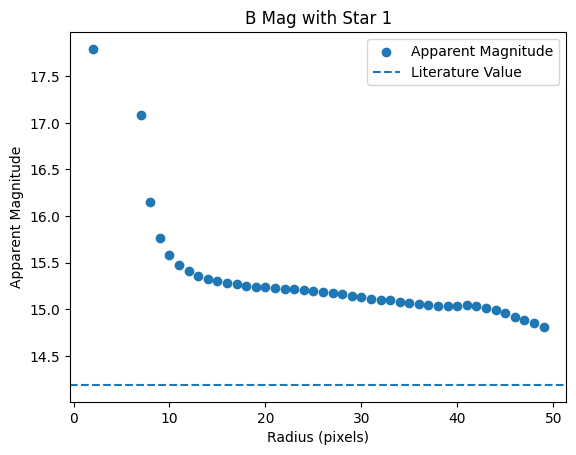

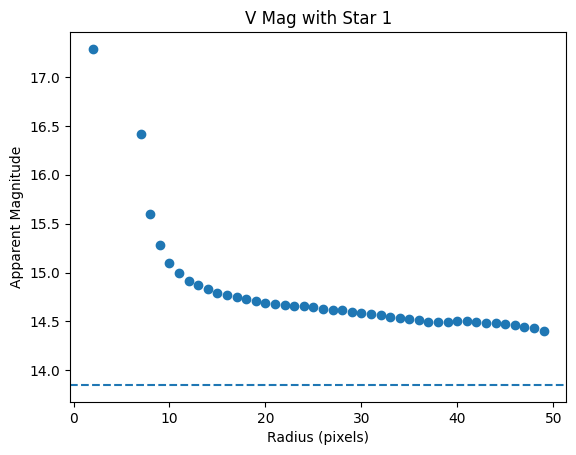

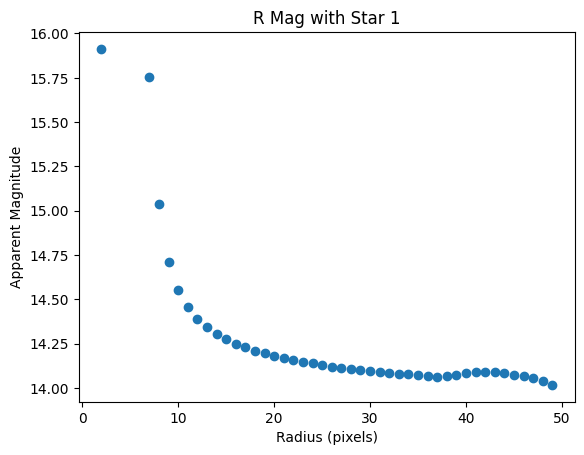

In [418]:
plt.figure()
plt.scatter(range(1,50),B_mags_star_1,label = 'Apparent Magnitude')
plt.axhline(14.19,label = 'Literature Value',linestyle = '--')
plt.xlabel('Radius (pixels)')
plt.ylabel('Apparent Magnitude')
plt.legend()
plt.title('B Mag with Star 1')
plt.show()

plt.figure()
plt.scatter(range(1,50),V_mags_star_1,label = 'Apparent Magnitude')
plt.axhline(13.85,label = 'Literature Value',linestyle = '--')
plt.xlabel('Radius (pixels)')
plt.ylabel('Apparent Magnitude')
plt.title('V Mag with Star 1')
plt.show()

plt.figure()
plt.scatter(range(1,50),R_mags_star_1,label = 'Apparent Magnitude')
plt.xlabel('Radius (pixels)')
plt.ylabel('Apparent Magnitude')
plt.title('R Mag with Star 1')
plt.show()

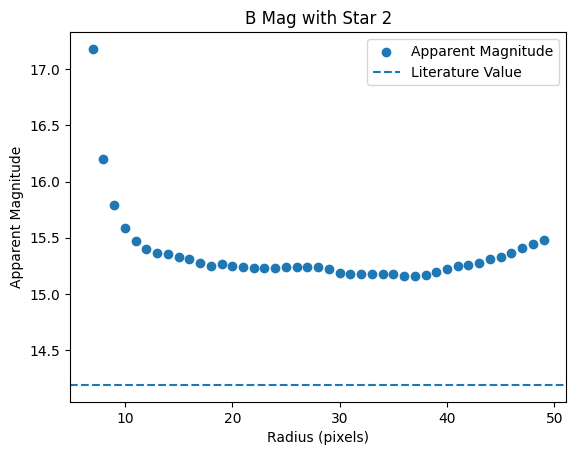

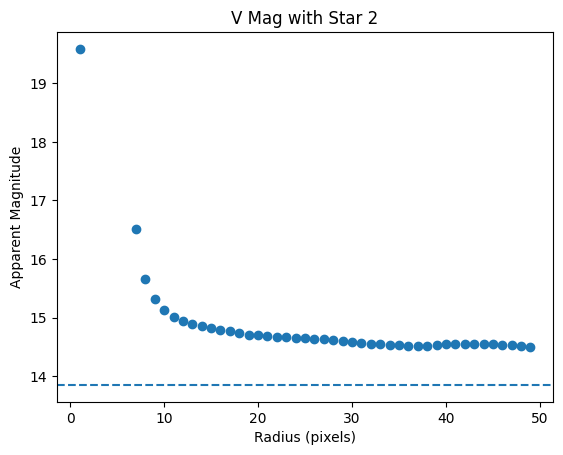

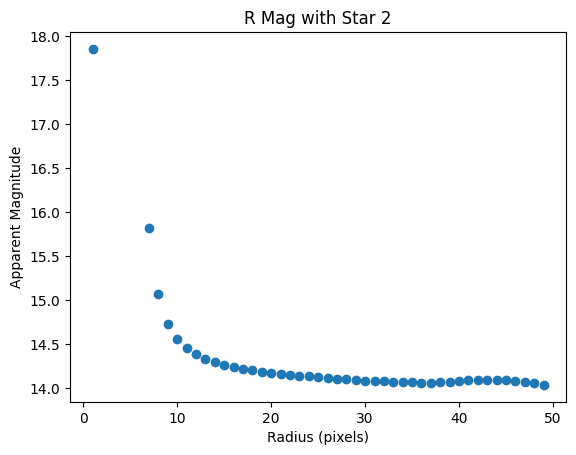

In [419]:
plt.figure()
plt.scatter(range(1,50),B_mags_star_2,label = 'Apparent Magnitude')
plt.axhline(14.19,label = 'Literature Value',linestyle = '--')
plt.xlabel('Radius (pixels)')
plt.ylabel('Apparent Magnitude')
plt.legend()
plt.title('B Mag with Star 2')
plt.show()

plt.figure()
plt.scatter(range(1,50),V_mags_star_2,label = 'Apparent Magnitude')
plt.axhline(13.85,label = 'Literature Value',linestyle = '--')
plt.xlabel('Radius (pixels)')
plt.ylabel('Apparent Magnitude')
plt.title('V Mag with Star 2')
plt.show()

plt.figure()
plt.scatter(range(1,50),R_mags_star_2,label = 'Apparent Magnitude')
plt.xlabel('Radius (pixels)')
plt.ylabel('Apparent Magnitude')
plt.title('R Mag with Star 2')
plt.show()

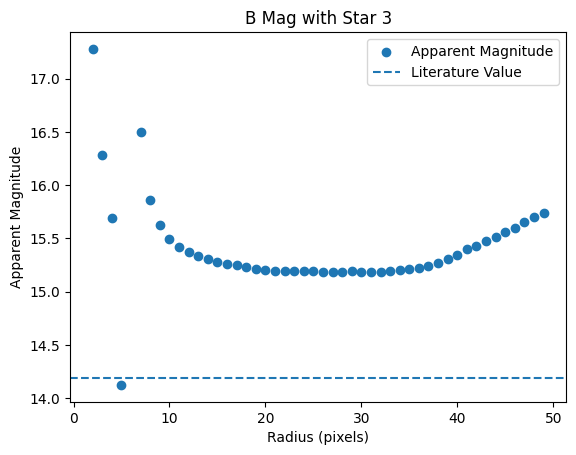

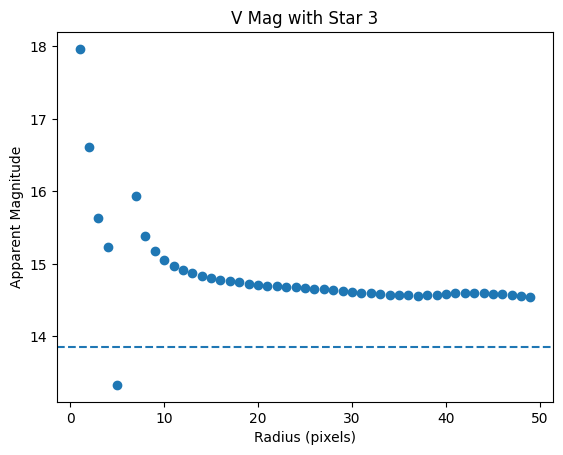

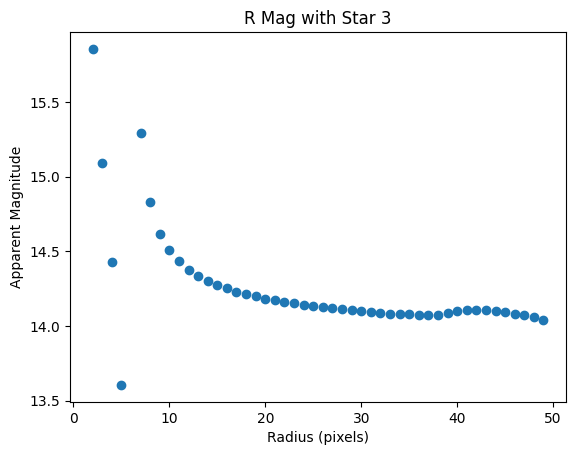

In [420]:
plt.figure()
plt.scatter(range(1,50),B_mags_star_3,label = 'Apparent Magnitude')
plt.axhline(14.19,label = 'Literature Value',linestyle = '--')
plt.xlabel('Radius (pixels)')
plt.ylabel('Apparent Magnitude')
plt.legend()
plt.title('B Mag with Star 3')
plt.show()

plt.figure()
plt.scatter(range(1,50),V_mags_star_3,label = 'Apparent Magnitude')
plt.axhline(13.85,label = 'Literature Value',linestyle = '--')
plt.xlabel('Radius (pixels)')
plt.ylabel('Apparent Magnitude')
plt.title('V Mag with Star 3')
plt.show()

plt.figure()
plt.scatter(range(1,50),R_mags_star_3,label = 'Apparent Magnitude')
plt.xlabel('Radius (pixels)')
plt.ylabel('Apparent Magnitude')
plt.title('R Mag with Star 3')
plt.show()

With this method, the radius of the aperture is very important. One must ensure that they take the correct size of the radius when selecting the star. Thus, we will try to manually look at the aperture and determain the best size. It is also important to note that the annulus selection method can be greatly improved over the version showed above by changing the annulus radius as as shown above. The above plots are just to illustrate the effect of the aperture. Now, we will inspect the aperture visually

<Figure size 640x480 with 0 Axes>

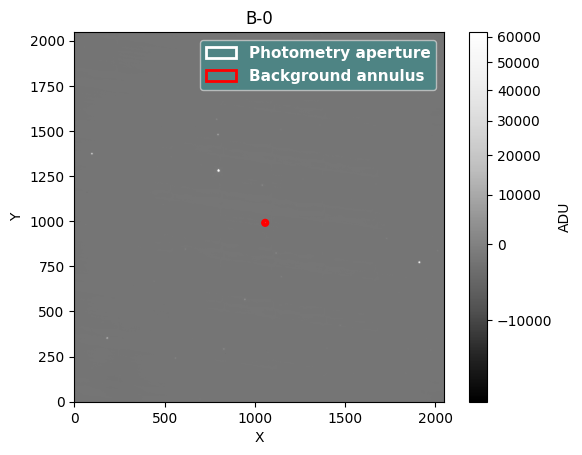

<Figure size 640x480 with 0 Axes>

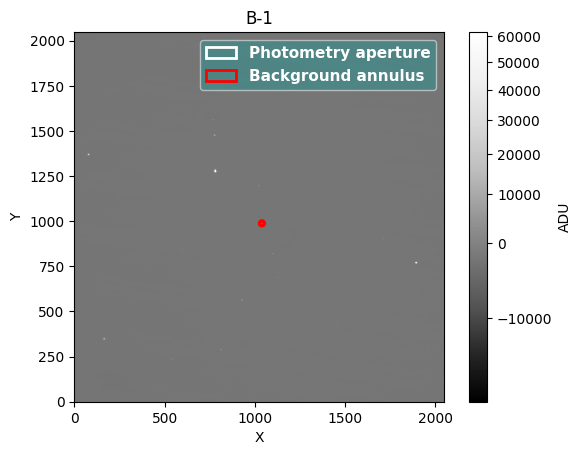

<Figure size 640x480 with 0 Axes>

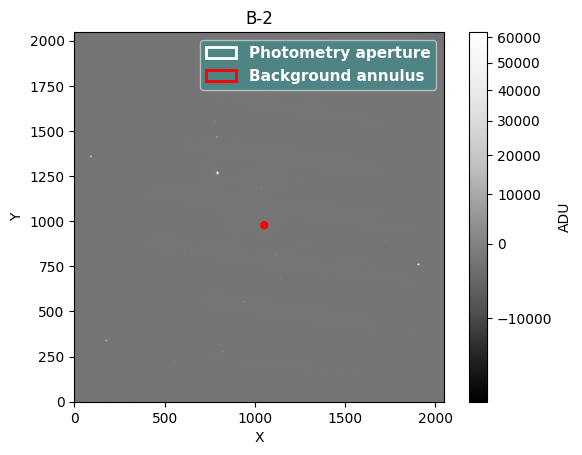

<Figure size 640x480 with 0 Axes>

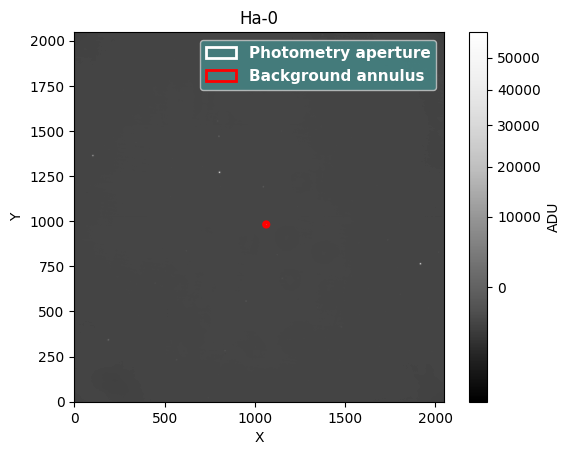

<Figure size 640x480 with 0 Axes>

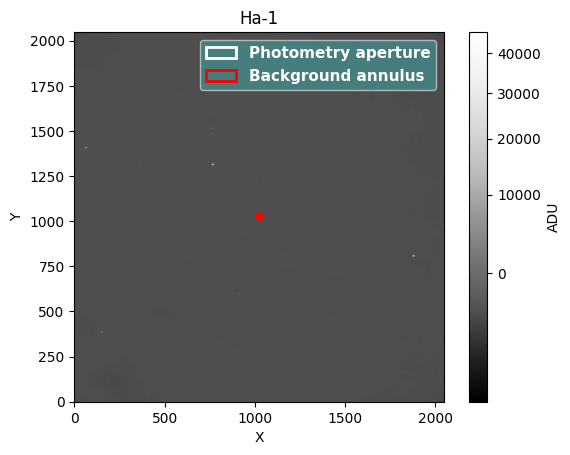

<Figure size 640x480 with 0 Axes>

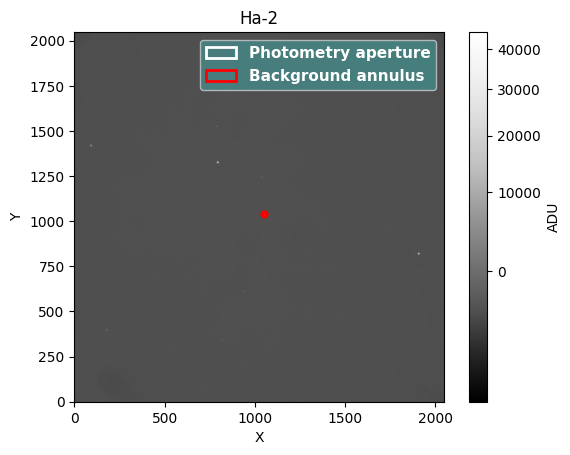

<Figure size 640x480 with 0 Axes>

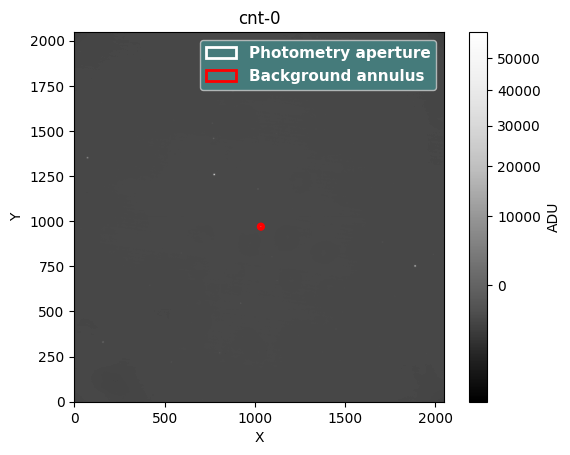

<Figure size 640x480 with 0 Axes>

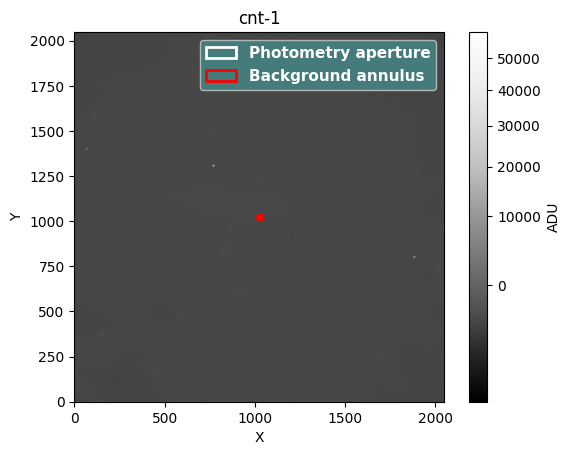

<Figure size 640x480 with 0 Axes>

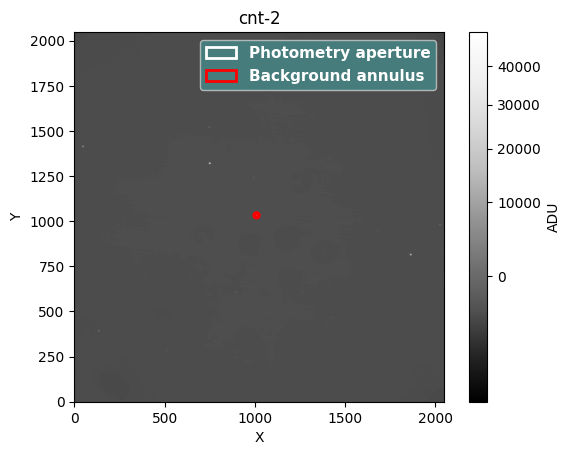

<Figure size 640x480 with 0 Axes>

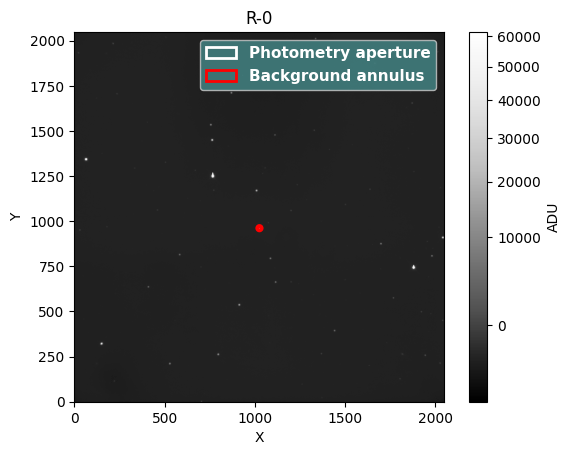

<Figure size 640x480 with 0 Axes>

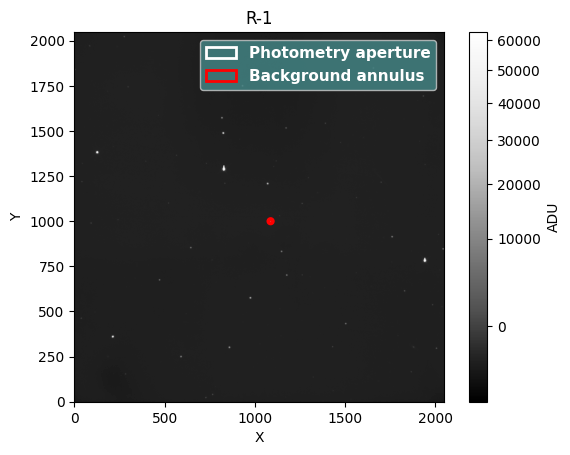

<Figure size 640x480 with 0 Axes>

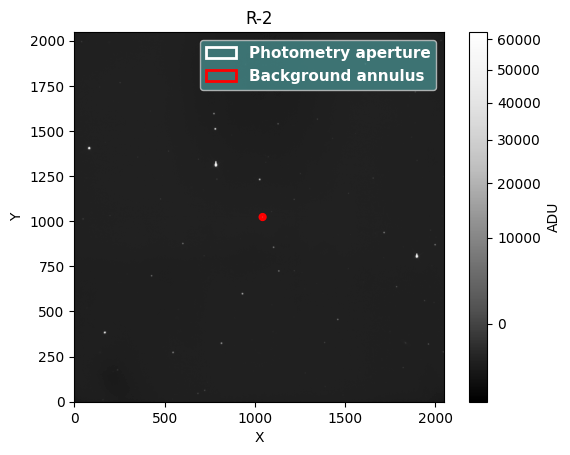

<Figure size 640x480 with 0 Axes>

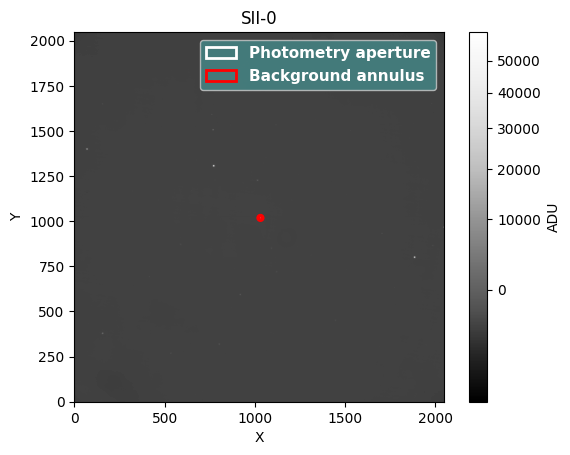

<Figure size 640x480 with 0 Axes>

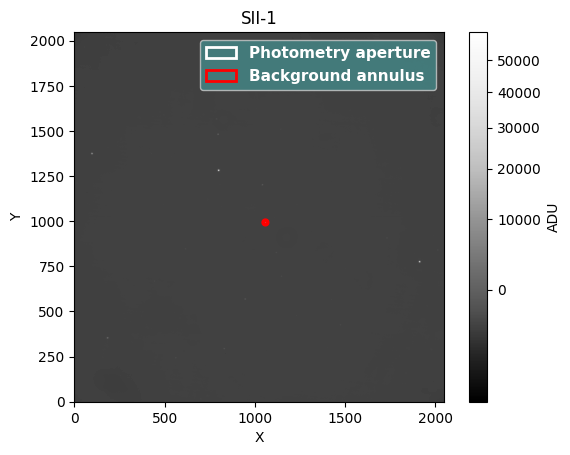

<Figure size 640x480 with 0 Axes>

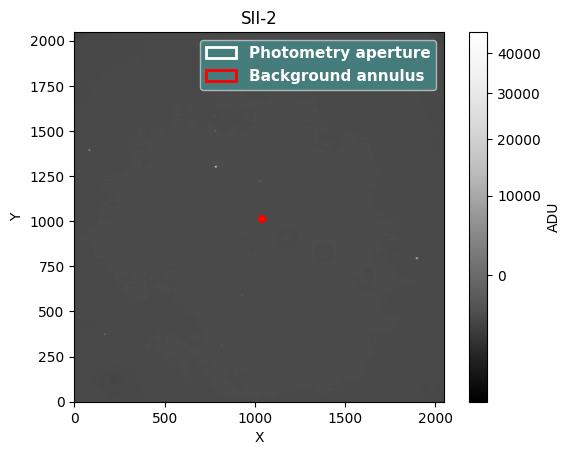

<Figure size 640x480 with 0 Axes>

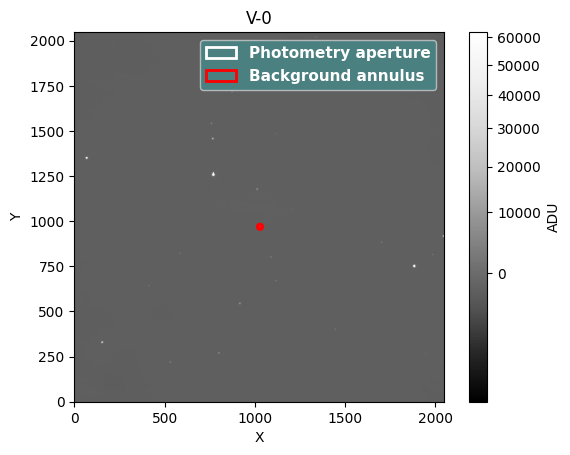

<Figure size 640x480 with 0 Axes>

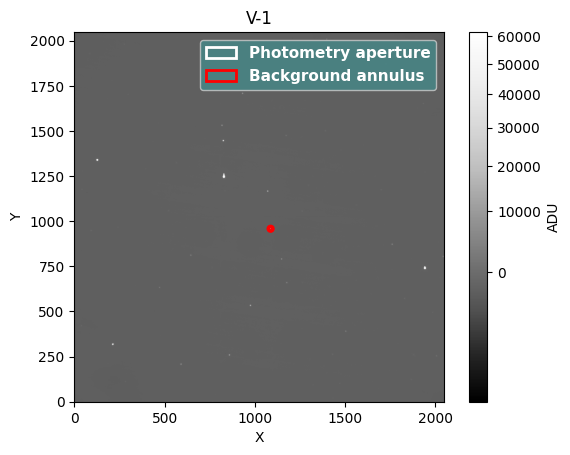

<Figure size 640x480 with 0 Axes>

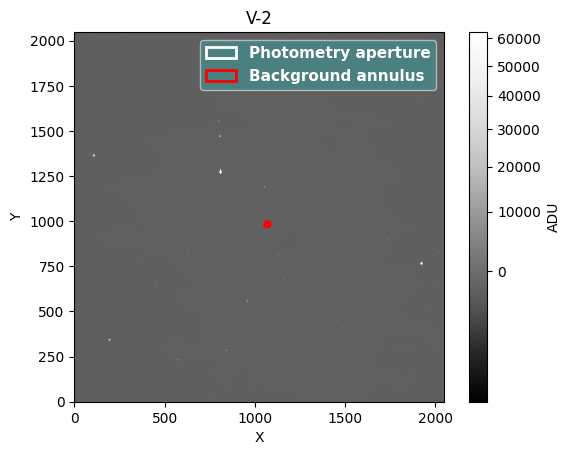

{'B': 34464.798751848786,
 'Ha': 6494.135643185611,
 'cnt': 5244.663372496764,
 'R': 83767.26068367244,
 'SII': 43700.579518547725,
 'V': 57442.84626786637}

In [421]:
aperture_selected_flux(Mrk335,Mrk335_coords_aperture,5,10,15,plot = True)

<Figure size 640x480 with 0 Axes>

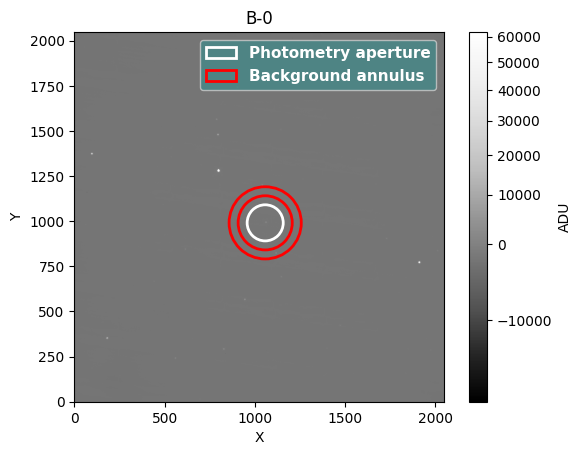

<Figure size 640x480 with 0 Axes>

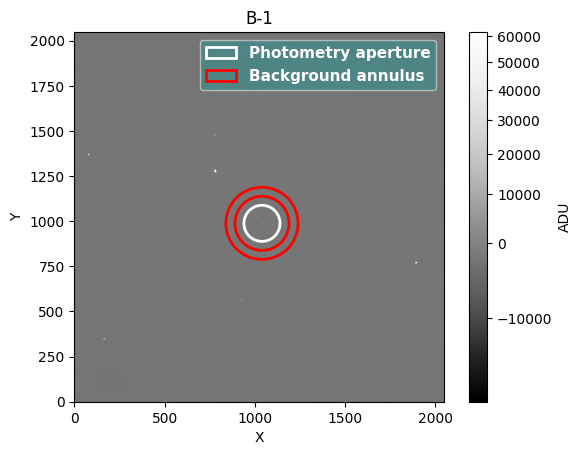

<Figure size 640x480 with 0 Axes>

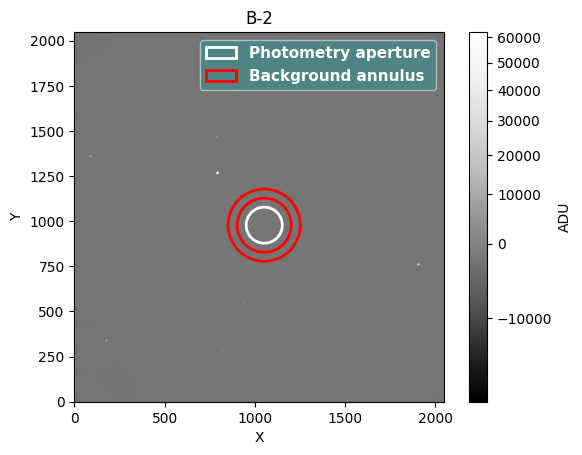

<Figure size 640x480 with 0 Axes>

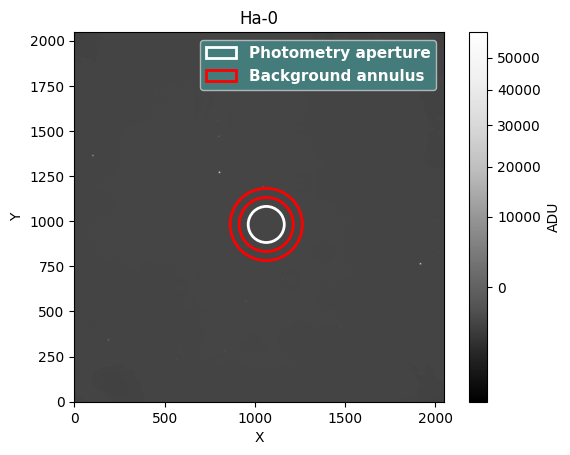

<Figure size 640x480 with 0 Axes>

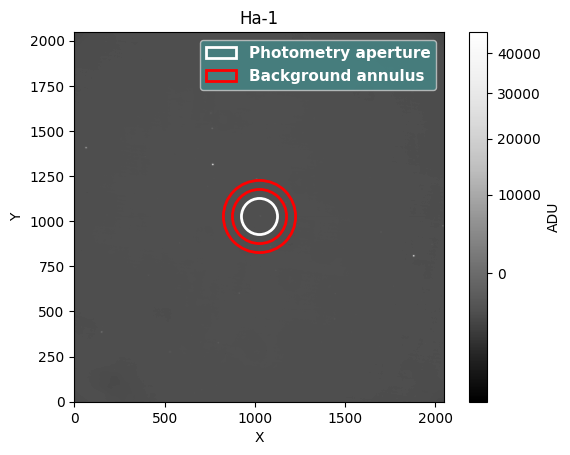

<Figure size 640x480 with 0 Axes>

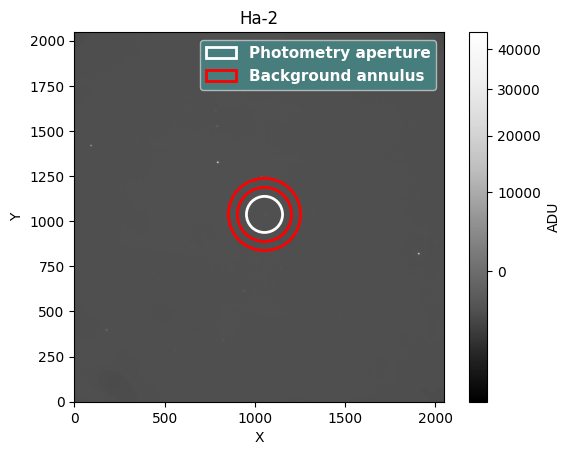

<Figure size 640x480 with 0 Axes>

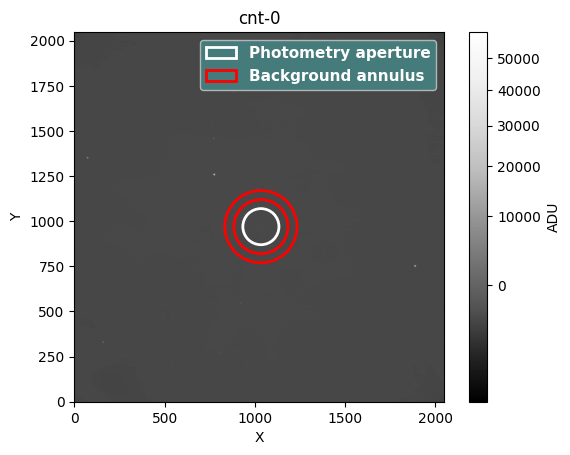

<Figure size 640x480 with 0 Axes>

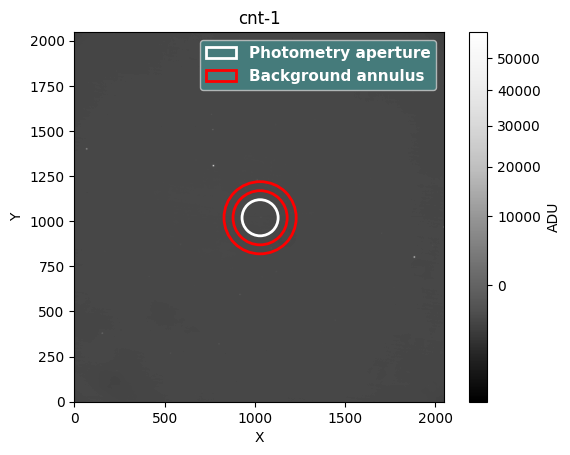

<Figure size 640x480 with 0 Axes>

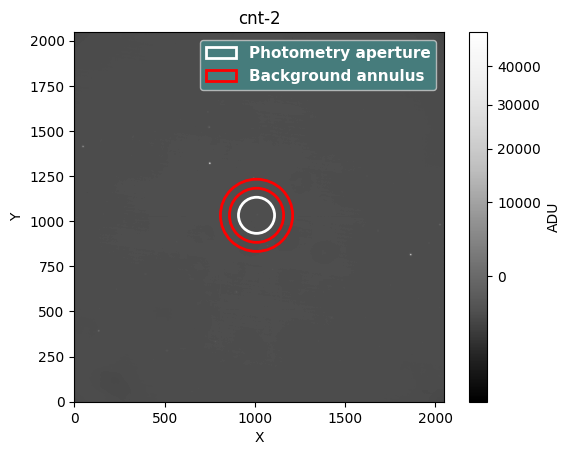

<Figure size 640x480 with 0 Axes>

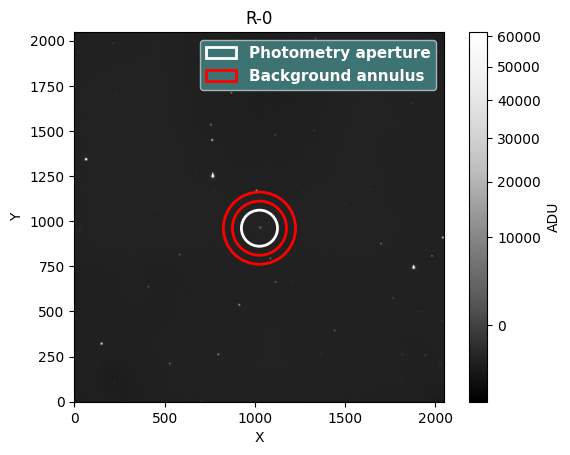

<Figure size 640x480 with 0 Axes>

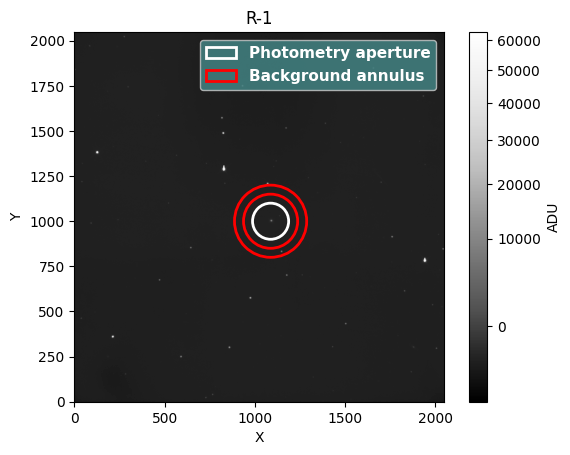

<Figure size 640x480 with 0 Axes>

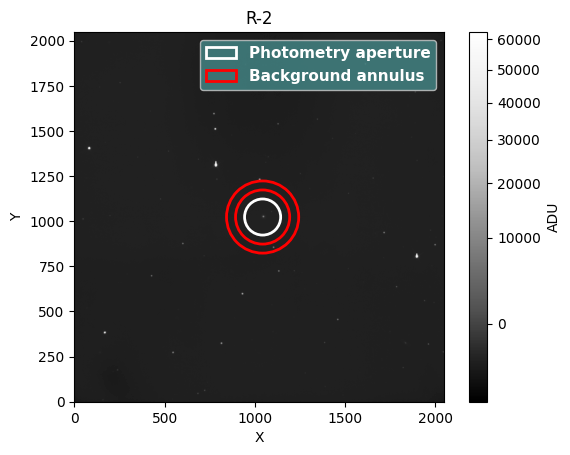

<Figure size 640x480 with 0 Axes>

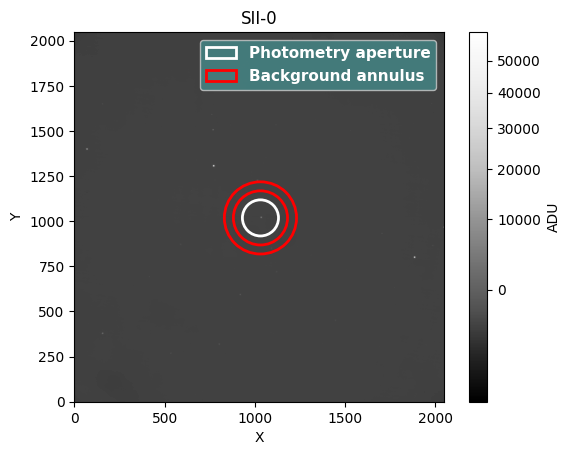

<Figure size 640x480 with 0 Axes>

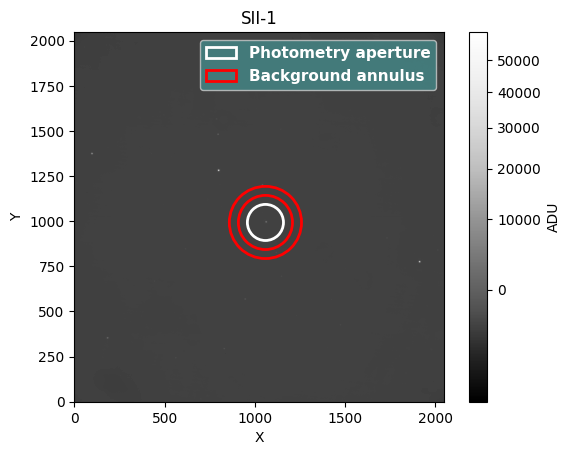

<Figure size 640x480 with 0 Axes>

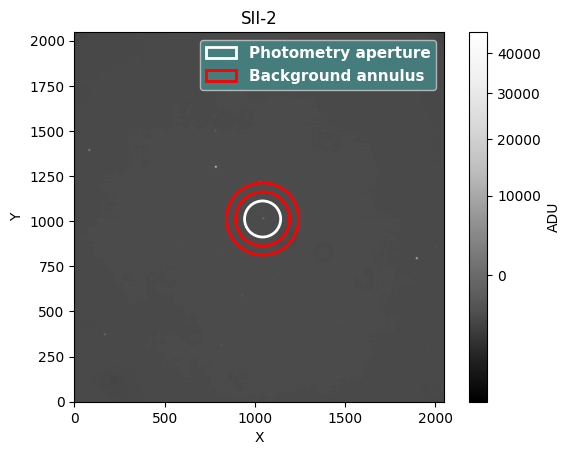

<Figure size 640x480 with 0 Axes>

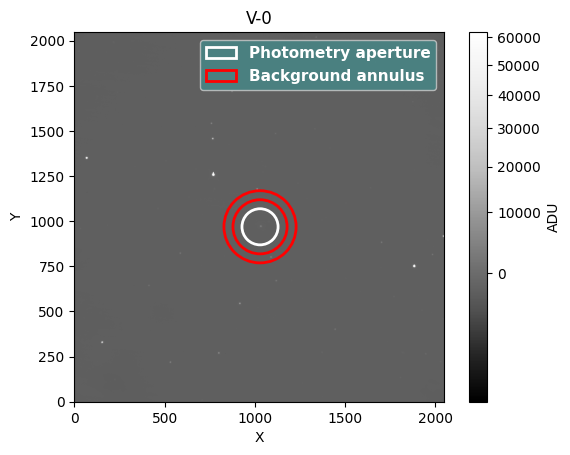

<Figure size 640x480 with 0 Axes>

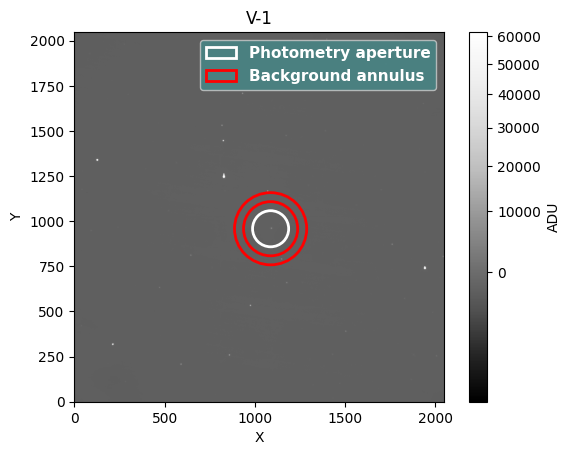

<Figure size 640x480 with 0 Axes>

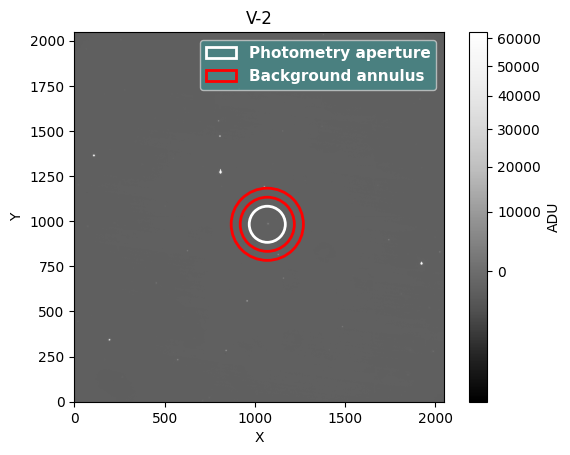

{'B': 802130.2659901679,
 'Ha': 656867.4420072237,
 'cnt': 615513.5853685836,
 'R': 1487113.5110773817,
 'SII': 1207536.4536820303,
 'V': 516269.64093061286}

In [422]:
aperture_selected_flux(Mrk335,Mrk335_coords_aperture,100,150,200,plot = True)

Clearly a small radius is much better. In fact, looking in DS9, the radius of the stars are roughly 5-20 pixels

<Figure size 640x480 with 0 Axes>

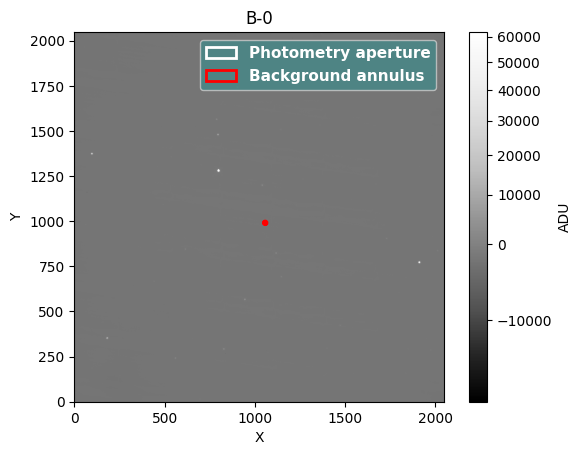

<Figure size 640x480 with 0 Axes>

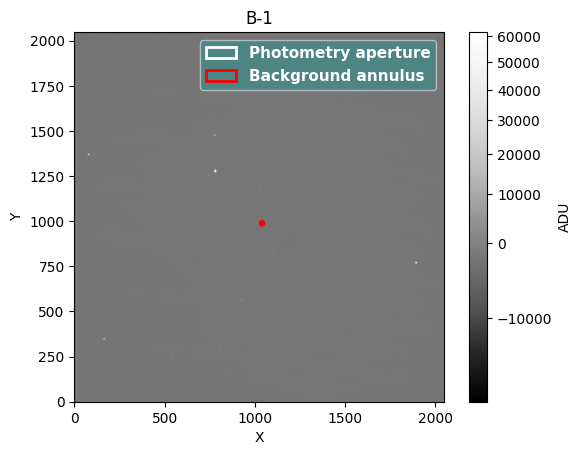

<Figure size 640x480 with 0 Axes>

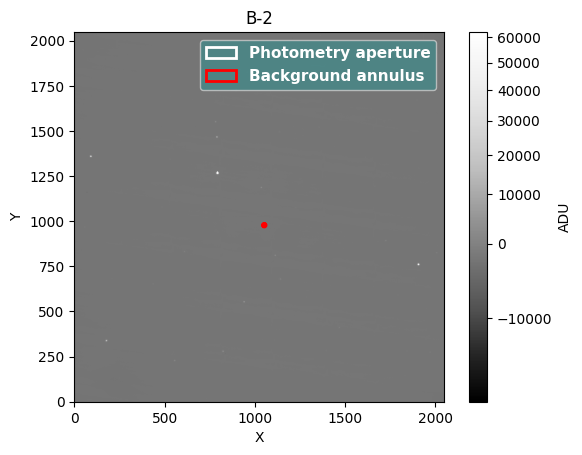

<Figure size 640x480 with 0 Axes>

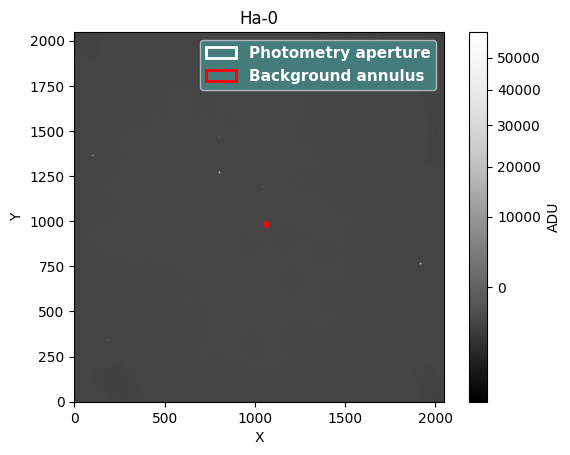

<Figure size 640x480 with 0 Axes>

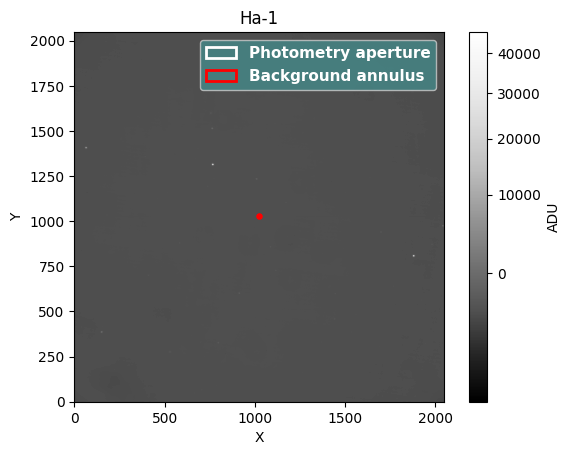

<Figure size 640x480 with 0 Axes>

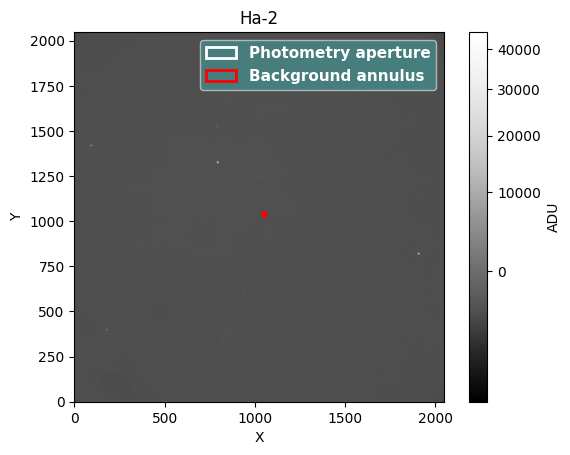

<Figure size 640x480 with 0 Axes>

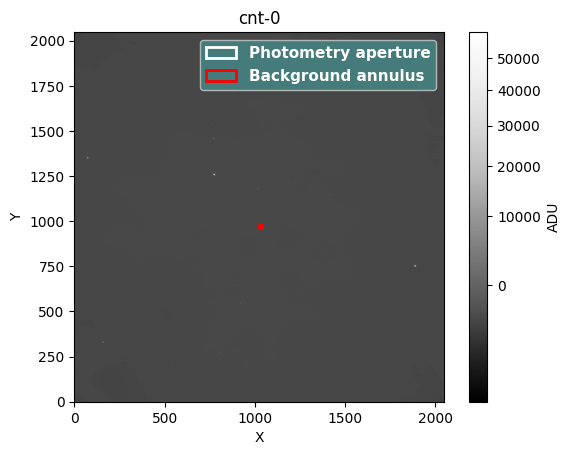

<Figure size 640x480 with 0 Axes>

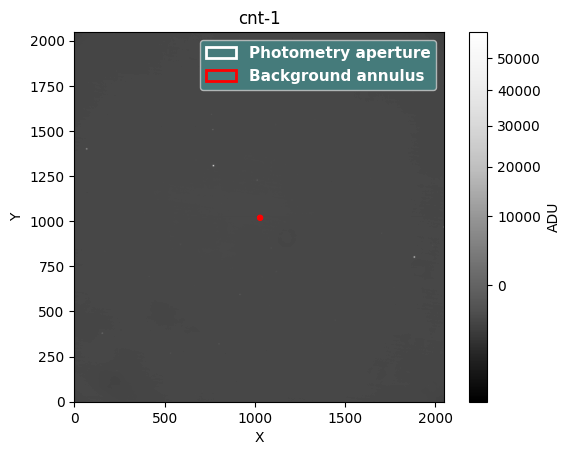

<Figure size 640x480 with 0 Axes>

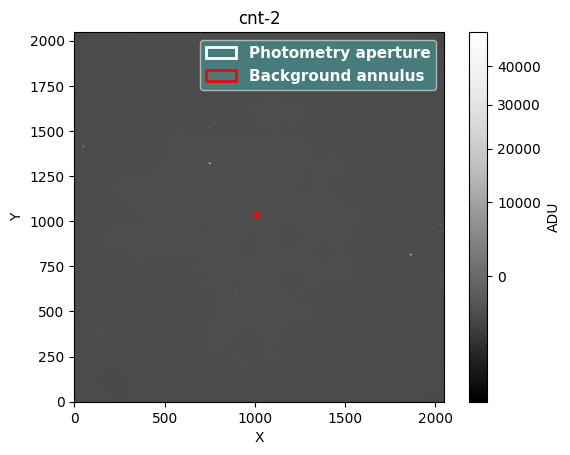

<Figure size 640x480 with 0 Axes>

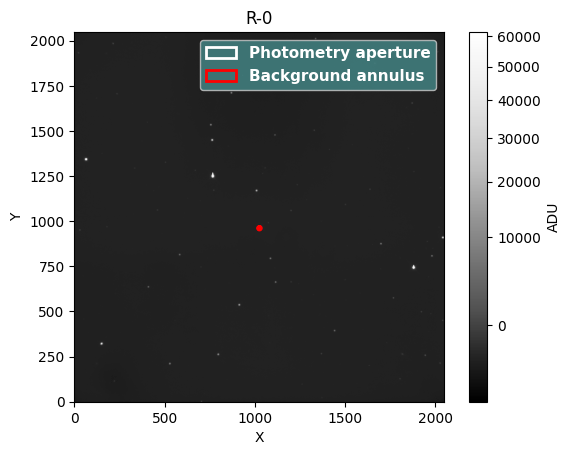

<Figure size 640x480 with 0 Axes>

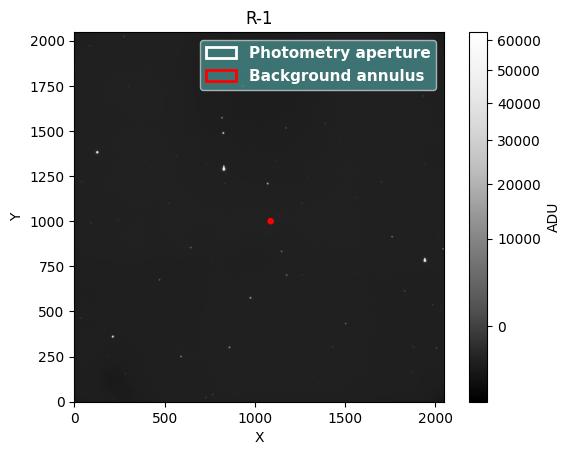

<Figure size 640x480 with 0 Axes>

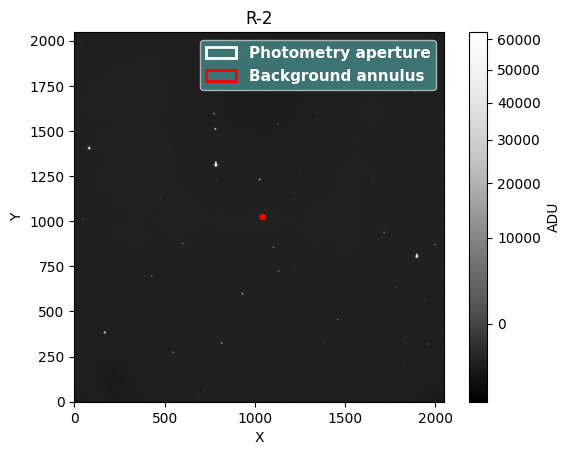

<Figure size 640x480 with 0 Axes>

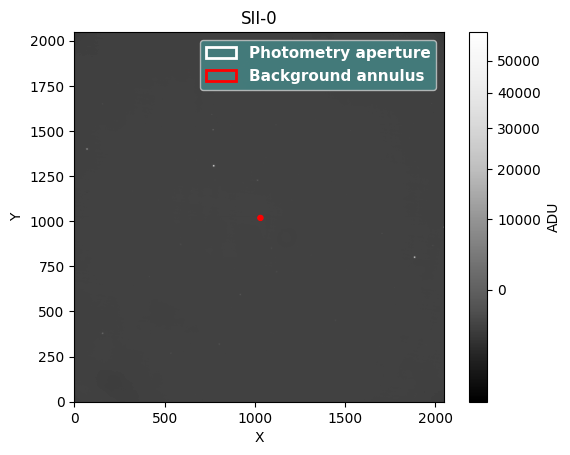

<Figure size 640x480 with 0 Axes>

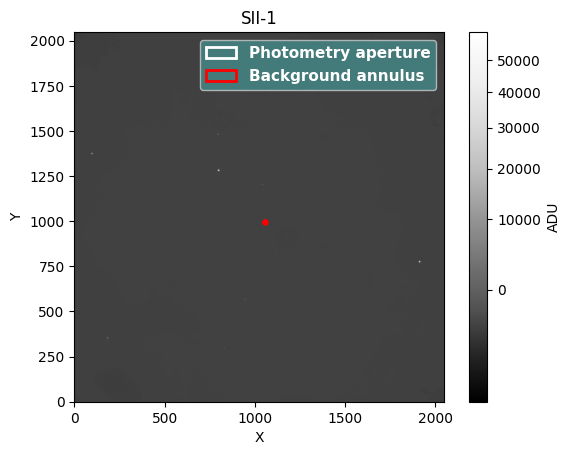

<Figure size 640x480 with 0 Axes>

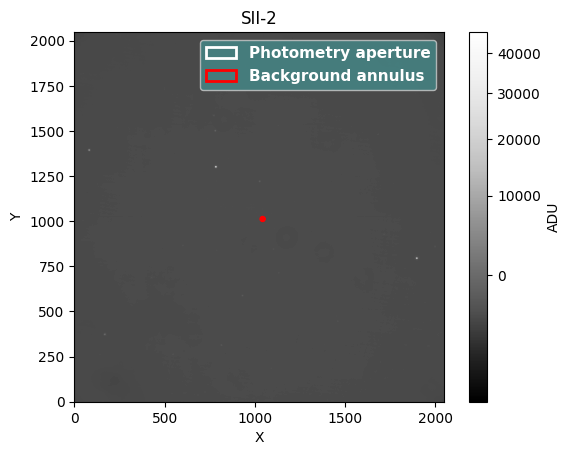

<Figure size 640x480 with 0 Axes>

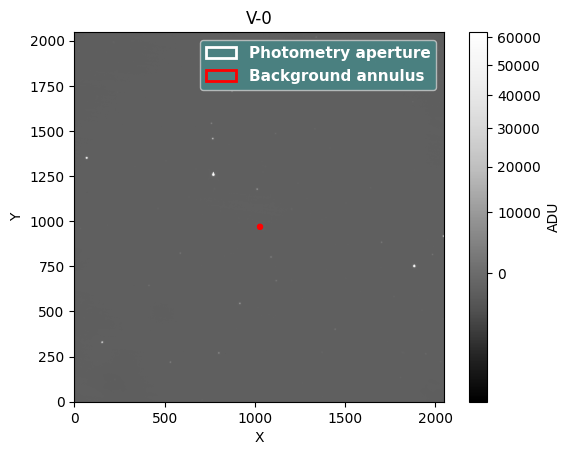

<Figure size 640x480 with 0 Axes>

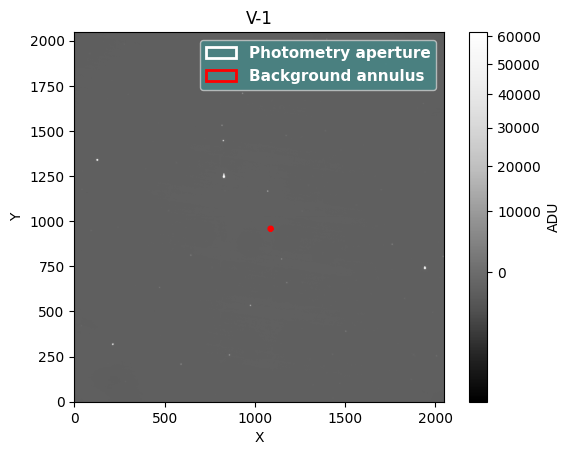

<Figure size 640x480 with 0 Axes>

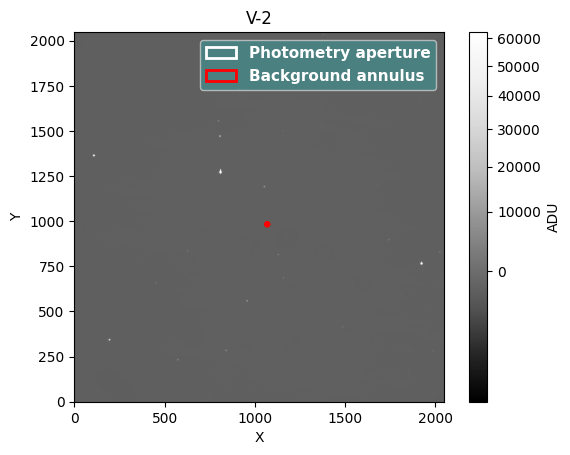

{'B': -8945.658467015533,
 'Ha': -1372.5250391456648,
 'cnt': -893.7382535080347,
 'R': -10864.428589660953,
 'SII': -13886.269481039693,
 'V': -8800.556264899677}

In [423]:
aperture_selected_flux(Mrk335,Mrk335_coords_aperture,5,7,10,plot = True)

This yields negative fluxes, so clearly the background is cutting into the source

<Figure size 640x480 with 0 Axes>

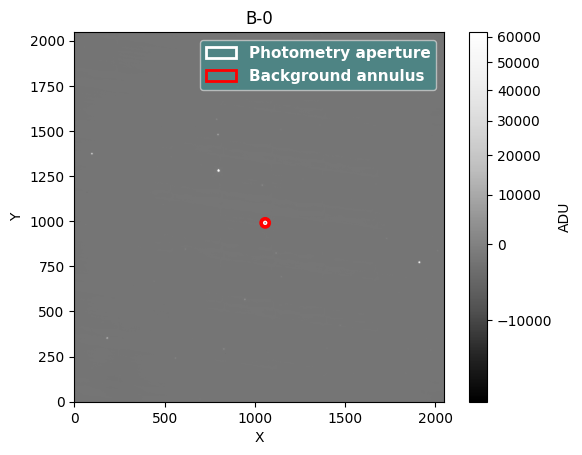

<Figure size 640x480 with 0 Axes>

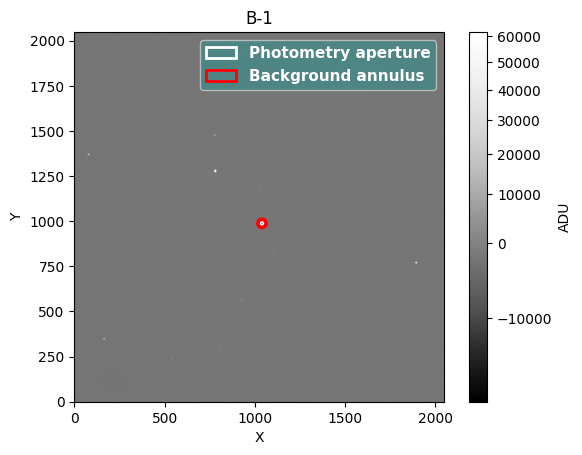

<Figure size 640x480 with 0 Axes>

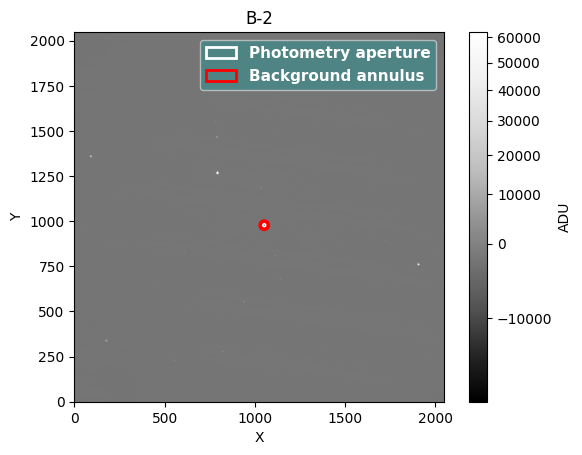

<Figure size 640x480 with 0 Axes>

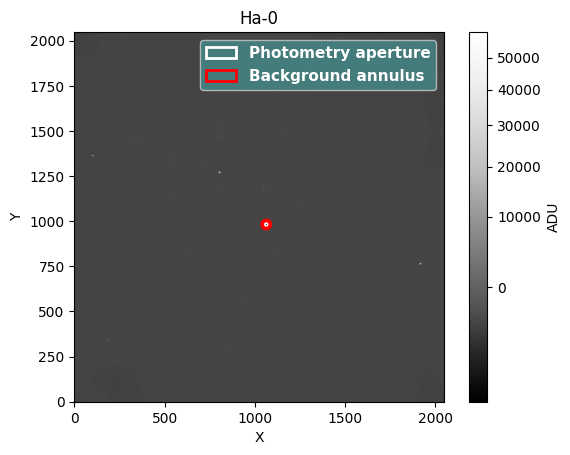

<Figure size 640x480 with 0 Axes>

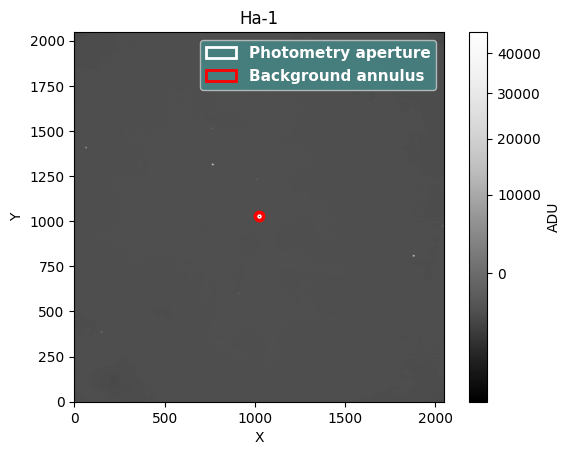

<Figure size 640x480 with 0 Axes>

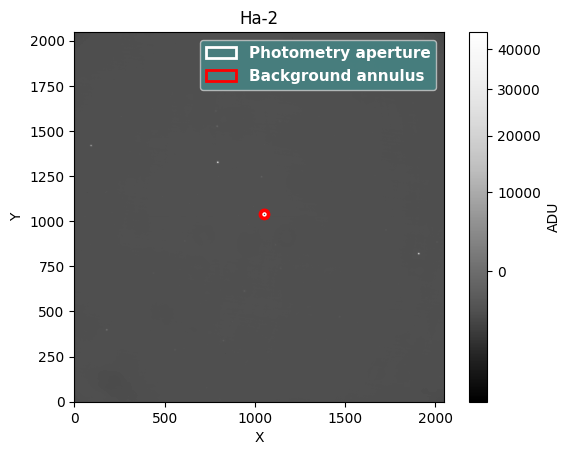

<Figure size 640x480 with 0 Axes>

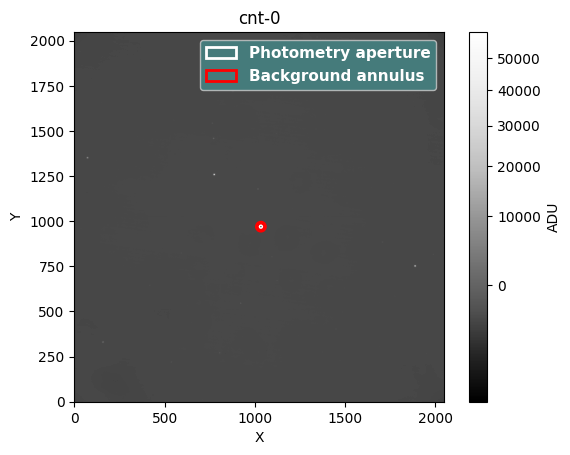

<Figure size 640x480 with 0 Axes>

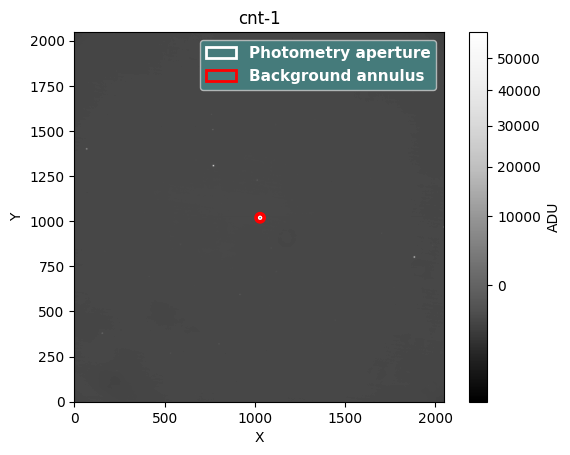

<Figure size 640x480 with 0 Axes>

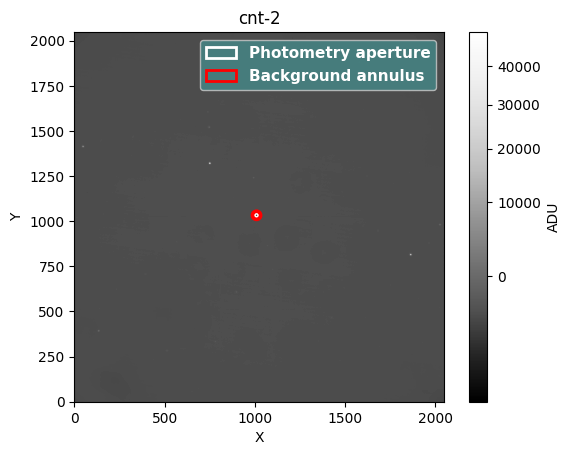

<Figure size 640x480 with 0 Axes>

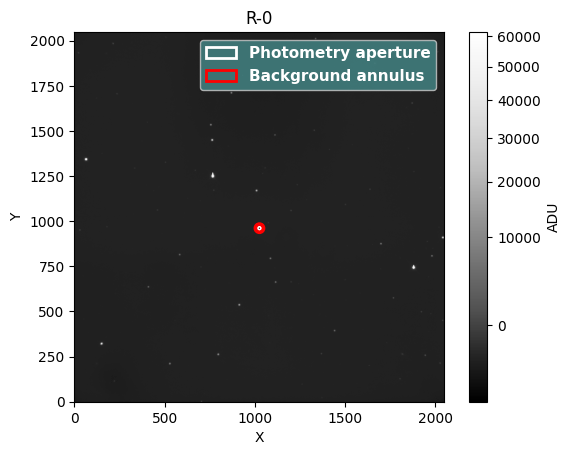

<Figure size 640x480 with 0 Axes>

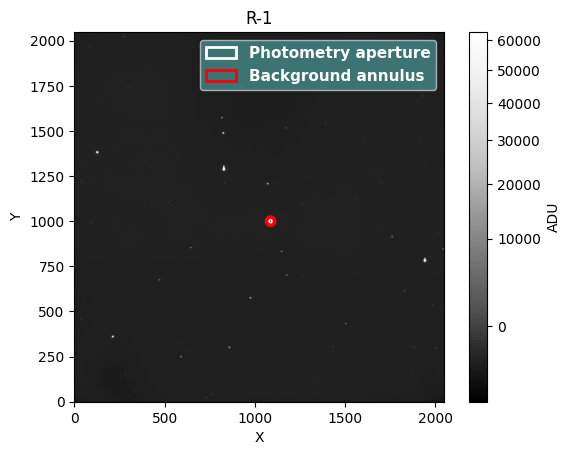

<Figure size 640x480 with 0 Axes>

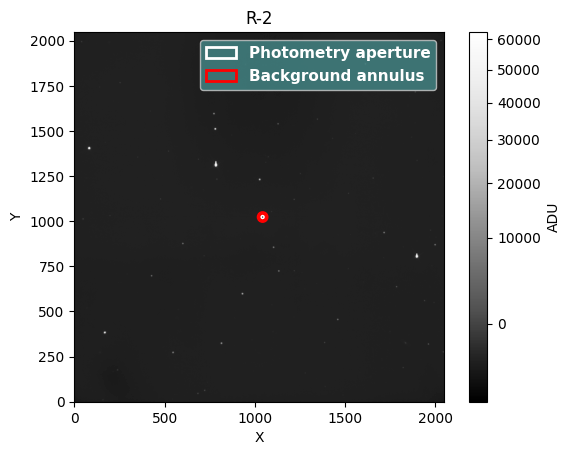

<Figure size 640x480 with 0 Axes>

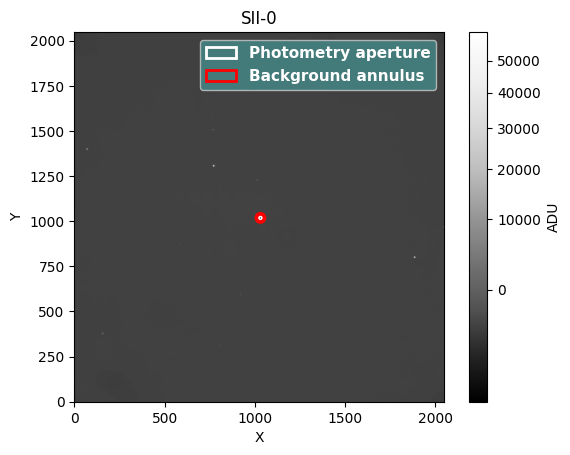

<Figure size 640x480 with 0 Axes>

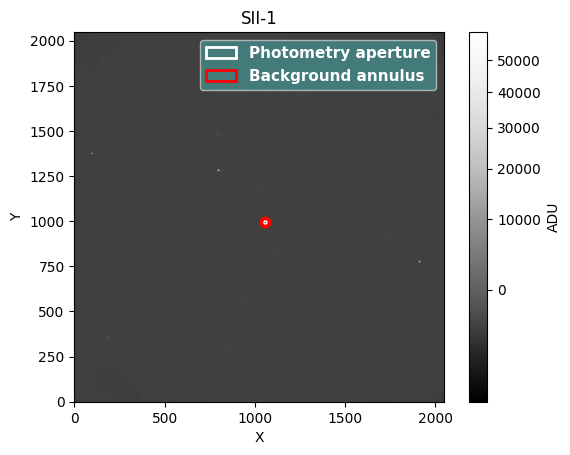

<Figure size 640x480 with 0 Axes>

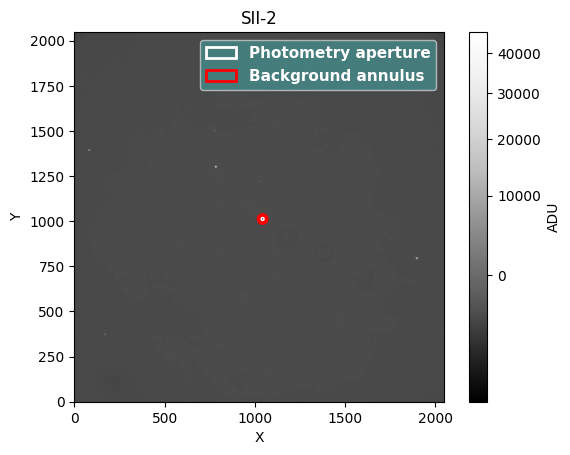

<Figure size 640x480 with 0 Axes>

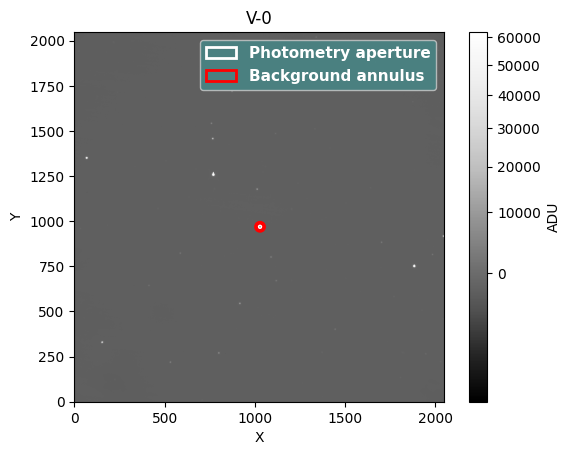

<Figure size 640x480 with 0 Axes>

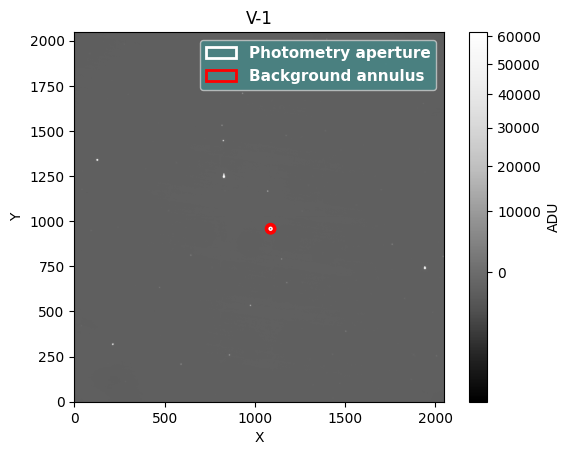

<Figure size 640x480 with 0 Axes>

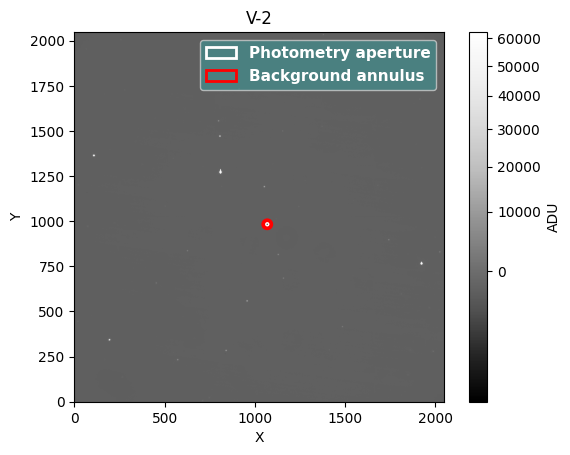

{'B': 260311.33616627532,
 'Ha': 45491.12431690601,
 'cnt': 38535.95919642722,
 'R': 597663.3330715334,
 'SII': 324963.03059841087,
 'V': 416494.3407461594}

In [405]:
r = 12
r_in = 20
r_out = 25

aperture_selected_flux(Mrk335,Mrk335_coords_aperture,r,r_in,r_out,plot = True)

We will use these values to finally report the magntiude of the AGN as we can see that the AGN is mostly in the photometry aperture and the background is in the back

In [406]:
final_mag_1 = flux_to_mag(Mrk335,Mrk335_coords_aperture,Standard_Star_1_coords_aperture,Standard_Star_1_mags,r,r_in,r_out)
final_mag_2 = flux_to_mag(Mrk335,Mrk335_coords_aperture,Standard_Star_2_coords_aperture,Standard_Star_2_mags,r,r_in,r_out)
final_mag_3 = flux_to_mag(Mrk335,Mrk335_coords_aperture,Standard_Star_3_coords_aperture,Standard_Star_3_mags,r,r_in,r_out)

In [407]:
aperture_final_am = pd.concat((pd.DataFrame(final_mag_1,['Star 1']),pd.DataFrame(final_mag_2,['Star 2']),pd.DataFrame(final_mag_3,['Star 3'])))

In [408]:
aperture_final_am[['B','R','V']]

B          R          V
Star 1  15.362634  14.328541  14.854691
Star 2  15.360515  14.326527  14.874242
Star 3  15.324083  14.320794  14.855146

In [410]:
#Final Absolute Magnitudes
aperture_final_am[['B','R','V']] - distance_modulus

B          R          V
Star 1 -20.367366 -21.401459 -20.875309
Star 2 -20.369485 -21.403473 -20.855758
Star 3 -20.405917 -21.409206 -20.874854

Once again, the apparent magnitudes are off by an order or so. This error could come from the poor calibration files and the problem with the bias and dark current